DQN (Deep Q-Network)

In [ ]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

from collections import deque
from tqdm import tqdm

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# CartPole-v1 review
- A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
- The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over.
- A reward of +1 is provided for every timestep that the pole remains upright.
  - The episode ends when the pole is more than 15 degrees from vertical,
  - or, the cart moves more than 2.4 units from the center.

In [ ]:
import gym
env = gym.make('CartPole-v1', new_step_api=True)  # 'new_step_api=True' is recommended
                                                  # 'done' flag separates 'termination' and 'truncation'
obs = env.reset(seed=42)              # initialize, env returns an observation

In [ ]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

- observation which containes:
  - horizontal position,
  - velocity,
  - angle (0 = vertical),
  - angular velocity)

In [ ]:
env.step(1)

(array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32),
 1.0,
 False,
 False,
 {})

In [ ]:
img = env.render(mode="rgb_array")  # to get an image of the environment as an array
img.shape

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


(400, 600, 3)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


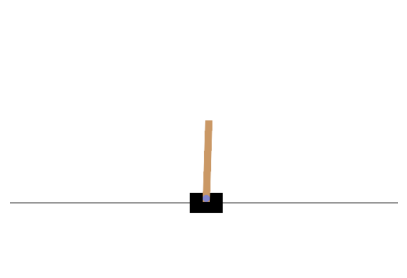

In [ ]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

- Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [ ]:
# dir(env)
print(env.action_space)  # two possible move actions(0(left) and 1(right))

Discrete(2)


In [ ]:
action = 1  # accelerate right
obs, reward, done, info, _ = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

In [ ]:
print(reward) # The environment also tells the agent how much reward it got during the last step
print(done) # When the game is over, the environment returns done=True:
print(info)  # environment-specific dictionary that can provide some extra information

1.0
False
False


- Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.


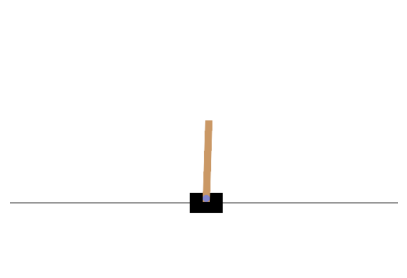

In [ ]:
plot_environment(env)
plt.show()

- The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True`), you should reset the environment before you continue to use it.

In [ ]:
if done:
    obs = env.reset()

- Now how can we make the poll remain upright? We will need to define a **_policy_** for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# Deep Q-Network

Let's build the DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after it plays that action (but before it sees its outcome):

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

import gym

env = gym.make("CartPole-v1", new_step_api=True)
input_shape = [4]         # env.observation_space.shape, the same as (4,)
n_outputs = 2             # env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [ ]:
####
a = np.array([1,2])
a, a[np.newaxis], a.shape, a[np.newaxis].shape,

(array([1, 2]), array([[1, 2]]), (2,), (1, 2))

To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probability `epsilon`.

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):  # default greedy
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

We will also need a replay memory. It will contain the agent's experiences, in the form of tuples: `(obs, action, reward, next_obs, done)`. We can use the `deque` class for that (but make sure to check out DeepMind's excellent [Reverb library](https://github.com/deepmind/reverb) for a much more robust implementation of experience replay):

In [ ]:
from collections import deque

replay_memory = deque(maxlen=2000)   # double-ended queue

In [ ]:
####
replay_memory

deque([])

And let's create a function to sample experiences from the replay memory. It will return 5 NumPy arrays: `[obs, actions, rewards, next_obs, dones]`.

In [ ]:
####
a = [[ 1, 2, 3, 4, 5],
     [11,12,13,14,15],
     [21,22,23,24,25],
     [31,32,33,34,35],
     [41,42,43,44,45]]

x, y, z = [[i[idx] for i in a]
                   for idx in range(3)]
print(x)
print(y)
print(z)

[1, 11, 21, 31, 41]
[2, 12, 22, 32, 42]
[3, 13, 23, 33, 43]


In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

Now we can create a function that will use the DQN to play one step, and record its experience in the replay memory:

In [ ]:
def play_one_step(state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info, _ = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [ ]:
####
state = [0.1, -0.5, 1.2, 0.4]
epsilon = 0.9
action = epsilon_greedy_policy(state, epsilon)
print(action)
env.step(action)

0


(array([ 0.02323877, -0.39734846,  0.04272482,  0.62740684], dtype=float32),
 1.0,
 False,
 False,
 {})

Lastly, let's create a function that will sample some experiences from the replay memory and perform a training step:

**Notes**:
* The first 3 releases of the 2nd edition were missing the `reshape()` operation which converts `target_Q_values` to a column vector (this is required by the `loss_fn()`).
* The book uses a learning rate of 1e-3, but in the code below I use 1e-2, as it significantly improves training. I also tuned the learning rates of the DQN variants below.

In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = np.max(next_Q_values, axis=1)

    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

And now, let's train the model!

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

# takes 36 min to train with 600 episodes in Colab
from tqdm import tqdm

for episode in tqdm(range(600)):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)    # go from 1 down to 0.01
        obs, reward, done, info = play_one_step(obs, epsilon)
        if done:
            break

    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info, _ = env.step(action)
    if done:
        print ("Fallen or went out of range after {} steps.".format(step))
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 17ms/step
Fallen or went out of range after 33 steps.


Not bad at all! 😀

In [ ]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

from collections import deque
from tqdm import tqdm

import gym

input_shape = [4]     # env.observation_space.shape, the same as (4,)
n_outputs = 2         # env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

env = gym.make("CartPole-v1", new_step_api=True)
replay_memory = deque(maxlen=2000)   # double-ended queue

def epsilon_greedy_policy(state, epsilon=0):  # default greedy
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

# def play_one_step(state, epsilon):
#    action = epsilon_greedy_policy(state, epsilon)
#    next_state, reward, done, info, _ = env.step(action)
#    replay_memory.append((state, action, reward, next_state, done))
#    return next_state, reward, done, info

batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)

    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

# takes 36 min to train with 600 episodes in Colab

for episode in tqdm(range(1000)):
    state = env.reset()   # state = obs
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)    # go from 1 down to 0.01

        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, info, _ = env.step(action)
        replay_memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            break

    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Putting all together

In [ ]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

from collections import deque
from tqdm import tqdm

import gym

input_shape = [4]     # env.observation_space.shape, the same as (4,)
n_outputs = 2         # env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

env = gym.make("CartPole-v1", new_step_api=True)
replay_memory = deque(maxlen=2000)   # double-ended queue

def epsilon_greedy_policy(state, epsilon=0):  # default greedy
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

# def play_one_step(state, epsilon):
#    action = epsilon_greedy_policy(state, epsilon)
#    next_state, reward, done, info, _ = env.step(action)
#    replay_memory.append((state, action, reward, next_state, done))
#    return next_state, reward, done, info

batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    next_Q_values = model.predict(next_states)  ###
    max_next_Q_values = np.max(next_Q_values, axis=1)

    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)  ###
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

# takes 36 min to train with 600 episodes in Colab

for episode in tqdm(range(600)):
    state = env.reset()   # state = obs
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)    # go from 1 down to 0.01

        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, info, _ = env.step(action)
        replay_memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            break

    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

- DQN:
  - DQN was introduced by DeepMind in 2013. It combines Q-learning with deep neural networks to approximate the Q-function, which estimates the expected future rewards for taking a particular action in a given state.
  - One of the key challenges in training DQN is the issue of overestimation bias, which can lead to suboptimal policies. This happens because the Q-values tend to be overestimated due to the maximization operation used in the Q-learning update rule.
  - DQN uses a technique called Experience Replay, where it stores experiences (state, action, reward, next state) in a replay buffer and samples mini-batches from it during training. This helps to decorrelate the experiences and improve learning stability.
- Overestimation: the tendency of a learning algorithm to estimate a quantity (in the context of reinforcement learning, this is the Q-value) to be higher than its true value. In the case of Q-learning algorithms like DQN, this can lead to suboptimal policies because the agent believes that certain actions are more valuable than they actually are. This can be problematic as it may result in the agent making poor decisions.

## Two DQNs
- online model: for choosing the action, and it learns at each step
- target model: only for defining the targets (clone of the online model)

  1%|          | 7/600 [00:01<01:32,  6.39it/s]

Episode: 9, Steps: 79, eps: 0.982

  2%|▎         | 15/600 [00:01<00:42, 13.63it/s]

Episode: 17, Steps: 14, eps: 0.966

  4%|▍         | 24/600 [00:01<00:26, 21.75it/s]

Episode: 26, Steps: 19, eps: 0.948

  5%|▍         | 28/600 [00:02<00:22, 25.23it/s]

Episode: 30, Steps: 17, eps: 0.940

  6%|▌         | 35/600 [00:02<00:27, 20.20it/s]

Episode: 36, Steps: 18, eps: 0.928

  7%|▋         | 41/600 [00:03<00:36, 15.23it/s]

Episode: 40, Steps: 11, eps: 0.920

  7%|▋         | 43/600 [00:03<00:46, 12.00it/s]

Episode: 43, Steps: 13, eps: 0.914

  8%|▊         | 49/600 [00:03<00:30, 17.93it/s]

Episode: 51, Steps: 16, eps: 0.898

  9%|▉         | 54/600 [00:05<01:25,  6.37it/s]

Episode: 54, Steps: 22, eps: 0.892

  9%|▉         | 56/600 [00:05<01:35,  5.70it/s]

Episode: 57, Steps: 29, eps: 0.886

 10%|█         | 60/600 [00:06<01:15,  7.15it/s]

Episode: 60, Steps: 13, eps: 0.880

 10%|█         | 62/600 [00:06<01:07,  8.01it/s]

Episode: 63, Steps: 17, eps: 0.874

 11%|█         | 65/600 [00:06<01:19,  6.76it/s]

Episode: 65, Steps: 35, eps: 0.870

 11%|█▏        | 68/600 [00:07<01:14,  7.10it/s]

Episode: 67, Steps: 16, eps: 0.866

 12%|█▏        | 70/600 [00:07<01:11,  7.46it/s]

Episode: 69, Steps: 26, eps: 0.862

 12%|█▏        | 71/600 [00:07<01:13,  7.17it/s]

Episode: 70, Steps: 17, eps: 0.860

 12%|█▏        | 72/600 [00:07<01:23,  6.34it/s]

Episode: 72, Steps: 14, eps: 0.856

 12%|█▏        | 74/600 [00:08<01:47,  4.91it/s]

Episode: 73, Steps: 20, eps: 0.854

 12%|█▎        | 75/600 [00:08<01:53,  4.63it/s]

Episode: 75, Steps: 12, eps: 0.850

 13%|█▎        | 77/600 [00:09<02:04,  4.20it/s]

Episode: 77, Steps: 15, eps: 0.846

 13%|█▎        | 79/600 [00:09<01:42,  5.10it/s]

Episode: 79, Steps: 13, eps: 0.842

 14%|█▎        | 81/600 [00:09<01:32,  5.63it/s]

Episode: 81, Steps: 10, eps: 0.838

 14%|█▍        | 84/600 [00:10<01:21,  6.31it/s]

Episode: 83, Steps: 19, eps: 0.834

 14%|█▍        | 86/600 [00:10<01:06,  7.68it/s]

Episode: 85, Steps: 10, eps: 0.830

 14%|█▍        | 87/600 [00:10<01:09,  7.36it/s]

Episode: 86, Steps: 18, eps: 0.828

 15%|█▍        | 88/600 [00:10<01:41,  5.05it/s]

Episode: 87, Steps: 16, eps: 0.826

 15%|█▍        | 89/600 [00:11<01:49,  4.65it/s]

Episode: 89, Steps: 14, eps: 0.822

 15%|█▌        | 91/600 [00:11<01:47,  4.75it/s]

Episode: 91, Steps: 17, eps: 0.818

 16%|█▌        | 94/600 [00:12<01:48,  4.68it/s]

Episode: 93, Steps: 14, eps: 0.814

 16%|█▌        | 95/600 [00:12<01:45,  4.78it/s]

Episode: 94, Steps: 17, eps: 0.812

 16%|█▌        | 96/600 [00:12<02:01,  4.14it/s]

Episode: 95, Steps: 10, eps: 0.810

 16%|█▌        | 97/600 [00:12<01:56,  4.32it/s]

Episode: 97, Steps: 13, eps: 0.806

 16%|█▋        | 99/600 [00:13<01:49,  4.56it/s]

Episode: 98, Steps: 20, eps: 0.804

 17%|█▋        | 100/600 [00:13<01:47,  4.64it/s]

Episode: 100, Steps: 15, eps: 0.800

 17%|█▋        | 102/600 [00:14<02:25,  3.42it/s]

Episode: 101, Steps: 65, eps: 0.798

 17%|█▋        | 103/600 [00:14<02:25,  3.41it/s]

Episode: 102, Steps: 28, eps: 0.796

 17%|█▋        | 104/600 [00:14<02:24,  3.44it/s]

Episode: 104, Steps: 12, eps: 0.792

 18%|█▊        | 106/600 [00:15<02:08,  3.85it/s]

Episode: 105, Steps: 18, eps: 0.790

 18%|█▊        | 107/600 [00:15<01:59,  4.12it/s]

Episode: 106, Steps: 11, eps: 0.788

 18%|█▊        | 108/600 [00:15<01:58,  4.14it/s]

Episode: 107, Steps: 18, eps: 0.786

 18%|█▊        | 110/600 [00:16<02:27,  3.31it/s]

Episode: 109, Steps: 13, eps: 0.782

 18%|█▊        | 111/600 [00:16<02:14,  3.65it/s]

Episode: 110, Steps: 14, eps: 0.780

 19%|█▊        | 112/600 [00:16<02:18,  3.51it/s]

Episode: 111, Steps: 14, eps: 0.778

 19%|█▉        | 114/600 [00:17<01:49,  4.43it/s]

Episode: 113, Steps: 16, eps: 0.774

 19%|█▉        | 115/600 [00:17<01:54,  4.22it/s]

Episode: 114, Steps: 20, eps: 0.772

 19%|█▉        | 116/600 [00:17<02:13,  3.62it/s]

Episode: 116, Steps: 15, eps: 0.768

 20%|█▉        | 118/600 [00:18<01:54,  4.20it/s]

Episode: 118, Steps: 18, eps: 0.764

 20%|██        | 120/600 [00:18<01:49,  4.39it/s]

Episode: 119, Steps: 16, eps: 0.762

 20%|██        | 121/600 [00:19<01:57,  4.07it/s]

Episode: 120, Steps: 18, eps: 0.760

 20%|██        | 122/600 [00:19<01:57,  4.08it/s]

Episode: 121, Steps: 10, eps: 0.758

 20%|██        | 123/600 [00:19<02:16,  3.49it/s]

Episode: 122, Steps: 36, eps: 0.756

 21%|██        | 124/600 [00:20<02:42,  2.92it/s]

Episode: 123, Steps: 43, eps: 0.754

 21%|██        | 125/600 [00:20<03:03,  2.59it/s]

Episode: 124, Steps: 19, eps: 0.752

 21%|██        | 126/600 [00:20<02:48,  2.80it/s]

Episode: 125, Steps: 13, eps: 0.750

 21%|██        | 127/600 [00:21<02:39,  2.97it/s]

Episode: 126, Steps: 19, eps: 0.748

 21%|██▏       | 128/600 [00:21<02:42,  2.90it/s]

Episode: 128, Steps: 12, eps: 0.744

 22%|██▏       | 131/600 [00:22<01:53,  4.12it/s]

Episode: 130, Steps: 18, eps: 0.740

 22%|██▏       | 132/600 [00:22<01:46,  4.38it/s]

Episode: 132, Steps: 13, eps: 0.736

 22%|██▏       | 134/600 [00:22<01:58,  3.94it/s]

Episode: 134, Steps: 17, eps: 0.732

 23%|██▎       | 136/600 [00:23<01:46,  4.36it/s]

Episode: 135, Steps: 31, eps: 0.730

 23%|██▎       | 137/600 [00:23<01:54,  4.06it/s]

Episode: 136, Steps: 21, eps: 0.728

 23%|██▎       | 138/600 [00:23<01:46,  4.33it/s]

Episode: 137, Steps: 14, eps: 0.726

 23%|██▎       | 139/600 [00:24<03:21,  2.28it/s]

Episode: 138, Steps: 51, eps: 0.724

 23%|██▎       | 140/600 [00:25<03:30,  2.19it/s]

Episode: 139, Steps: 50, eps: 0.722

 24%|██▎       | 141/600 [00:25<02:59,  2.55it/s]

Episode: 141, Steps: 12, eps: 0.718

 24%|██▍       | 143/600 [00:25<02:20,  3.26it/s]

Episode: 142, Steps: 18, eps: 0.716

 24%|██▍       | 144/600 [00:26<02:11,  3.48it/s]

Episode: 143, Steps: 19, eps: 0.714

 24%|██▍       | 145/600 [00:26<02:04,  3.65it/s]

Episode: 144, Steps: 18, eps: 0.712

 24%|██▍       | 146/600 [00:26<02:42,  2.80it/s]

Episode: 145, Steps: 35, eps: 0.710

 24%|██▍       | 147/600 [00:27<02:25,  3.10it/s]

Episode: 146, Steps: 13, eps: 0.708

 25%|██▍       | 148/600 [00:27<02:19,  3.24it/s]

Episode: 147, Steps: 11, eps: 0.706

 25%|██▍       | 149/600 [00:27<02:24,  3.12it/s]

Episode: 148, Steps: 12, eps: 0.704

 25%|██▌       | 150/600 [00:28<02:14,  3.34it/s]

Episode: 149, Steps: 11, eps: 0.702

 25%|██▌       | 151/600 [00:28<02:13,  3.36it/s]

Episode: 150, Steps: 12, eps: 0.700

 26%|██▌       | 153/600 [00:28<01:55,  3.86it/s]

Episode: 152, Steps: 10, eps: 0.696

 26%|██▌       | 154/600 [00:29<01:53,  3.94it/s]

Episode: 153, Steps: 16, eps: 0.694

 26%|██▌       | 155/600 [00:29<01:56,  3.81it/s]

Episode: 154, Steps: 10, eps: 0.692

 26%|██▌       | 156/600 [00:30<03:02,  2.43it/s]

Episode: 155, Steps: 49, eps: 0.690

 26%|██▌       | 157/600 [00:31<04:25,  1.67it/s]

Episode: 156, Steps: 63, eps: 0.688

 26%|██▋       | 158/600 [00:31<03:37,  2.03it/s]

Episode: 157, Steps: 15, eps: 0.686

 26%|██▋       | 159/600 [00:31<03:17,  2.23it/s]

Episode: 158, Steps: 14, eps: 0.684

 27%|██▋       | 160/600 [00:32<03:16,  2.24it/s]

Episode: 159, Steps: 27, eps: 0.682

 27%|██▋       | 161/600 [00:32<03:02,  2.41it/s]

Episode: 160, Steps: 16, eps: 0.680

 27%|██▋       | 162/600 [00:32<02:44,  2.66it/s]

Episode: 161, Steps: 15, eps: 0.678

 27%|██▋       | 163/600 [00:33<02:45,  2.64it/s]

Episode: 162, Steps: 19, eps: 0.676

 27%|██▋       | 164/600 [00:33<02:33,  2.83it/s]

Episode: 163, Steps: 16, eps: 0.674

 28%|██▊       | 165/600 [00:33<02:18,  3.13it/s]

Episode: 164, Steps: 18, eps: 0.672

 28%|██▊       | 166/600 [00:34<03:42,  1.95it/s]

Episode: 165, Steps: 46, eps: 0.670

 28%|██▊       | 167/600 [00:34<03:02,  2.37it/s]

Episode: 166, Steps: 16, eps: 0.668

 28%|██▊       | 168/600 [00:36<04:48,  1.50it/s]

Episode: 167, Steps: 70, eps: 0.666

 28%|██▊       | 169/600 [00:36<04:03,  1.77it/s]

Episode: 168, Steps: 20, eps: 0.664

 28%|██▊       | 170/600 [00:36<03:38,  1.97it/s]

Episode: 169, Steps: 30, eps: 0.662

 28%|██▊       | 171/600 [00:37<03:27,  2.07it/s]

Episode: 170, Steps: 27, eps: 0.660

 29%|██▊       | 172/600 [00:37<03:55,  1.82it/s]

Episode: 171, Steps: 29, eps: 0.658

 29%|██▉       | 173/600 [00:38<04:41,  1.51it/s]

Episode: 172, Steps: 48, eps: 0.656

 29%|██▉       | 174/600 [00:40<05:48,  1.22it/s]

Episode: 173, Steps: 95, eps: 0.654

 29%|██▉       | 175/600 [00:41<06:22,  1.11it/s]

Episode: 174, Steps: 57, eps: 0.652

 29%|██▉       | 176/600 [00:41<05:44,  1.23it/s]

Episode: 175, Steps: 29, eps: 0.650

 30%|██▉       | 177/600 [00:42<05:23,  1.31it/s]

Episode: 176, Steps: 29, eps: 0.648

 30%|██▉       | 178/600 [00:42<04:22,  1.61it/s]

Episode: 177, Steps: 14, eps: 0.646

 30%|██▉       | 179/600 [00:43<03:51,  1.82it/s]

Episode: 178, Steps: 14, eps: 0.644

 30%|███       | 180/600 [00:43<03:12,  2.18it/s]

Episode: 179, Steps: 21, eps: 0.642

 30%|███       | 181/600 [00:43<03:14,  2.15it/s]

Episode: 180, Steps: 35, eps: 0.640

 30%|███       | 182/600 [00:44<02:45,  2.52it/s]

Episode: 182, Steps: 15, eps: 0.636

 31%|███       | 184/600 [00:44<02:04,  3.35it/s]

Episode: 183, Steps: 13, eps: 0.634

 31%|███       | 185/600 [00:44<02:13,  3.10it/s]

Episode: 184, Steps: 10, eps: 0.632

 31%|███       | 186/600 [00:45<02:20,  2.96it/s]

Episode: 185, Steps: 22, eps: 0.630

 31%|███       | 187/600 [00:45<02:07,  3.23it/s]

Episode: 186, Steps: 14, eps: 0.628

 31%|███▏      | 188/600 [00:45<02:10,  3.16it/s]

Episode: 187, Steps: 16, eps: 0.626

 32%|███▏      | 189/600 [00:46<02:01,  3.37it/s]

Episode: 188, Steps: 12, eps: 0.624

 32%|███▏      | 190/600 [00:46<02:24,  2.83it/s]

Episode: 189, Steps: 31, eps: 0.622

 32%|███▏      | 191/600 [00:47<02:51,  2.38it/s]

Episode: 190, Steps: 31, eps: 0.620

 32%|███▏      | 192/600 [00:47<03:08,  2.17it/s]

Episode: 191, Steps: 27, eps: 0.618

 32%|███▏      | 193/600 [00:48<03:58,  1.70it/s]

Episode: 192, Steps: 33, eps: 0.616

 32%|███▏      | 194/600 [00:49<03:54,  1.73it/s]

Episode: 193, Steps: 34, eps: 0.614

 32%|███▎      | 195/600 [00:49<03:46,  1.79it/s]

Episode: 194, Steps: 25, eps: 0.612

 33%|███▎      | 196/600 [00:50<03:40,  1.83it/s]

Episode: 195, Steps: 17, eps: 0.610

 33%|███▎      | 197/600 [00:50<03:36,  1.86it/s]

Episode: 196, Steps: 20, eps: 0.608

 33%|███▎      | 198/600 [00:51<03:27,  1.93it/s]

Episode: 197, Steps: 23, eps: 0.606

 33%|███▎      | 199/600 [00:51<03:01,  2.21it/s]

Episode: 198, Steps: 20, eps: 0.604

 33%|███▎      | 200/600 [00:51<02:33,  2.61it/s]

Episode: 199, Steps: 12, eps: 0.602

 34%|███▎      | 201/600 [00:51<02:18,  2.88it/s]

Episode: 200, Steps: 16, eps: 0.600

 34%|███▎      | 202/600 [00:52<03:46,  1.76it/s]

Episode: 201, Steps: 38, eps: 0.598

 34%|███▍      | 203/600 [00:53<03:45,  1.76it/s]

Episode: 202, Steps: 53, eps: 0.596

 34%|███▍      | 204/600 [00:54<04:21,  1.52it/s]

Episode: 203, Steps: 38, eps: 0.594

 34%|███▍      | 205/600 [00:55<04:29,  1.47it/s]

Episode: 204, Steps: 33, eps: 0.592

 34%|███▍      | 206/600 [00:55<03:52,  1.70it/s]

Episode: 205, Steps: 17, eps: 0.590

 34%|███▍      | 207/600 [00:56<05:25,  1.21it/s]

Episode: 206, Steps: 71, eps: 0.588

 35%|███▍      | 208/600 [00:57<05:08,  1.27it/s]

Episode: 207, Steps: 22, eps: 0.586

 35%|███▍      | 209/600 [00:58<05:41,  1.14it/s]

Episode: 208, Steps: 52, eps: 0.584

 35%|███▌      | 210/600 [01:00<06:57,  1.07s/it]

Episode: 209, Steps: 102, eps: 0.582

 35%|███▌      | 211/600 [01:00<05:55,  1.09it/s]

Episode: 211, Steps: 12, eps: 0.578

 36%|███▌      | 213/600 [01:01<03:30,  1.84it/s]

Episode: 212, Steps: 23, eps: 0.576

 36%|███▌      | 214/600 [01:02<04:24,  1.46it/s]

Episode: 213, Steps: 38, eps: 0.574

 36%|███▌      | 215/600 [01:02<04:30,  1.42it/s]

Episode: 214, Steps: 29, eps: 0.572

 36%|███▌      | 216/600 [01:04<05:50,  1.09it/s]

Episode: 215, Steps: 80, eps: 0.570

 36%|███▌      | 217/600 [01:06<08:05,  1.27s/it]

Episode: 216, Steps: 81, eps: 0.568

 36%|███▋      | 218/600 [01:07<07:47,  1.22s/it]

Episode: 217, Steps: 49, eps: 0.566

 36%|███▋      | 219/600 [01:09<09:36,  1.51s/it]

Episode: 218, Steps: 91, eps: 0.564

 37%|███▋      | 220/600 [01:10<08:55,  1.41s/it]

Episode: 219, Steps: 61, eps: 0.562

 37%|███▋      | 221/600 [01:11<08:11,  1.30s/it]

Episode: 220, Steps: 46, eps: 0.560

 37%|███▋      | 222/600 [01:13<08:13,  1.30s/it]

Episode: 221, Steps: 61, eps: 0.558

 37%|███▋      | 223/600 [01:16<12:04,  1.92s/it]

Episode: 222, Steps: 168, eps: 0.556

 37%|███▋      | 224/600 [01:17<10:30,  1.68s/it]

Episode: 224, Steps: 9, eps: 0.552

 38%|███▊      | 226/600 [01:19<07:29,  1.20s/it]

Episode: 225, Steps: 62, eps: 0.550

 38%|███▊      | 227/600 [01:20<08:27,  1.36s/it]

Episode: 226, Steps: 88, eps: 0.548

 38%|███▊      | 228/600 [01:22<09:18,  1.50s/it]

Episode: 227, Steps: 75, eps: 0.546

 38%|███▊      | 229/600 [01:22<07:11,  1.16s/it]

Episode: 228, Steps: 18, eps: 0.544

 38%|███▊      | 230/600 [01:24<08:46,  1.42s/it]

Episode: 229, Steps: 92, eps: 0.542

 38%|███▊      | 231/600 [01:25<06:47,  1.10s/it]

Episode: 230, Steps: 15, eps: 0.540

 39%|███▊      | 232/600 [01:26<06:44,  1.10s/it]

Episode: 231, Steps: 41, eps: 0.538

 39%|███▉      | 233/600 [01:27<06:08,  1.00s/it]

Episode: 232, Steps: 29, eps: 0.536

 39%|███▉      | 234/600 [01:27<04:47,  1.27it/s]

Episode: 233, Steps: 12, eps: 0.534

 39%|███▉      | 235/600 [01:27<03:48,  1.60it/s]

Episode: 234, Steps: 11, eps: 0.532

 39%|███▉      | 236/600 [01:28<04:26,  1.36it/s]

Episode: 235, Steps: 54, eps: 0.530

 40%|███▉      | 237/600 [01:30<06:32,  1.08s/it]

Episode: 236, Steps: 91, eps: 0.528

 40%|███▉      | 238/600 [01:32<08:11,  1.36s/it]

Episode: 237, Steps: 89, eps: 0.526

 40%|███▉      | 239/600 [01:33<07:18,  1.21s/it]

Episode: 238, Steps: 36, eps: 0.524

 40%|████      | 240/600 [01:33<05:52,  1.02it/s]

Episode: 239, Steps: 15, eps: 0.522

 40%|████      | 241/600 [01:34<04:33,  1.31it/s]

Episode: 240, Steps: 11, eps: 0.520

 40%|████      | 242/600 [01:34<03:56,  1.51it/s]

Episode: 241, Steps: 10, eps: 0.518

 40%|████      | 243/600 [01:34<03:23,  1.76it/s]

Episode: 242, Steps: 9, eps: 0.516

 41%|████      | 244/600 [01:35<03:01,  1.96it/s]

Episode: 243, Steps: 12, eps: 0.514

 41%|████      | 245/600 [01:36<03:16,  1.81it/s]

Episode: 244, Steps: 32, eps: 0.512

 41%|████      | 246/600 [01:36<02:41,  2.19it/s]

Episode: 245, Steps: 10, eps: 0.510

 41%|████      | 247/600 [01:36<02:17,  2.58it/s]

Episode: 246, Steps: 14, eps: 0.508

 41%|████▏     | 248/600 [01:36<02:18,  2.54it/s]

Episode: 247, Steps: 11, eps: 0.506

 42%|████▏     | 249/600 [01:37<02:06,  2.77it/s]

Episode: 248, Steps: 12, eps: 0.504

 42%|████▏     | 250/600 [01:37<02:01,  2.88it/s]

Episode: 249, Steps: 11, eps: 0.502

 42%|████▏     | 251/600 [01:37<02:13,  2.61it/s]

Episode: 250, Steps: 12, eps: 0.500

 42%|████▏     | 252/600 [01:38<02:01,  2.85it/s]

Episode: 251, Steps: 17, eps: 0.498

 42%|████▏     | 253/600 [01:38<02:07,  2.72it/s]

Episode: 253, Steps: 14, eps: 0.494

 42%|████▎     | 255/600 [01:39<02:13,  2.59it/s]

Episode: 254, Steps: 30, eps: 0.492

 43%|████▎     | 256/600 [01:40<03:20,  1.71it/s]

Episode: 255, Steps: 34, eps: 0.490

 43%|████▎     | 257/600 [01:41<04:20,  1.32it/s]

Episode: 256, Steps: 48, eps: 0.488

 43%|████▎     | 258/600 [01:42<04:46,  1.19it/s]

Episode: 257, Steps: 35, eps: 0.486

 43%|████▎     | 259/600 [01:43<04:27,  1.27it/s]

Episode: 258, Steps: 21, eps: 0.484

 43%|████▎     | 260/600 [01:44<04:40,  1.21it/s]

Episode: 259, Steps: 36, eps: 0.482

 44%|████▎     | 261/600 [01:44<04:19,  1.31it/s]

Episode: 260, Steps: 22, eps: 0.480

 44%|████▎     | 262/600 [01:45<03:55,  1.43it/s]

Episode: 261, Steps: 16, eps: 0.478

 44%|████▍     | 263/600 [01:45<03:45,  1.49it/s]

Episode: 262, Steps: 20, eps: 0.476

 44%|████▍     | 264/600 [01:46<03:10,  1.76it/s]

Episode: 263, Steps: 18, eps: 0.474

 44%|████▍     | 265/600 [01:47<04:18,  1.29it/s]

Episode: 264, Steps: 27, eps: 0.472

 44%|████▍     | 266/600 [01:48<05:20,  1.04it/s]

Episode: 265, Steps: 41, eps: 0.470

 44%|████▍     | 267/600 [01:49<04:54,  1.13it/s]

Episode: 266, Steps: 27, eps: 0.468

 45%|████▍     | 268/600 [01:50<04:47,  1.15it/s]

Episode: 267, Steps: 25, eps: 0.466

 45%|████▍     | 269/600 [01:51<04:50,  1.14it/s]

Episode: 268, Steps: 28, eps: 0.464

 45%|████▌     | 270/600 [01:51<04:18,  1.28it/s]

Episode: 269, Steps: 20, eps: 0.462

 45%|████▌     | 271/600 [01:52<03:36,  1.52it/s]

Episode: 270, Steps: 16, eps: 0.460

 45%|████▌     | 272/600 [01:52<03:14,  1.69it/s]

Episode: 271, Steps: 16, eps: 0.458

 46%|████▌     | 273/600 [01:53<04:02,  1.35it/s]

Episode: 272, Steps: 52, eps: 0.456

 46%|████▌     | 274/600 [01:54<04:23,  1.24it/s]

Episode: 273, Steps: 30, eps: 0.454

 46%|████▌     | 275/600 [01:55<04:48,  1.13it/s]

Episode: 274, Steps: 37, eps: 0.452

 46%|████▌     | 276/600 [01:56<04:01,  1.34it/s]

Episode: 275, Steps: 22, eps: 0.450

 46%|████▌     | 277/600 [01:56<03:23,  1.59it/s]

Episode: 276, Steps: 13, eps: 0.448

 46%|████▋     | 278/600 [01:57<03:31,  1.52it/s]

Episode: 277, Steps: 28, eps: 0.446

 46%|████▋     | 279/600 [01:58<04:07,  1.29it/s]

Episode: 278, Steps: 55, eps: 0.444

 47%|████▋     | 280/600 [01:59<05:05,  1.05it/s]

Episode: 279, Steps: 40, eps: 0.442

 47%|████▋     | 281/600 [02:00<04:42,  1.13it/s]

Episode: 280, Steps: 25, eps: 0.440

 47%|████▋     | 282/600 [02:00<04:04,  1.30it/s]

Episode: 281, Steps: 15, eps: 0.438

 47%|████▋     | 283/600 [02:01<03:21,  1.57it/s]

Episode: 282, Steps: 10, eps: 0.436

 47%|████▋     | 284/600 [02:01<02:55,  1.80it/s]

Episode: 283, Steps: 9, eps: 0.434

 48%|████▊     | 285/600 [02:01<02:32,  2.06it/s]

Episode: 284, Steps: 13, eps: 0.432

 48%|████▊     | 286/600 [02:02<02:16,  2.29it/s]

Episode: 285, Steps: 10, eps: 0.430

 48%|████▊     | 287/600 [02:02<02:01,  2.57it/s]

Episode: 286, Steps: 12, eps: 0.428

 48%|████▊     | 288/600 [02:02<01:47,  2.91it/s]

Episode: 287, Steps: 11, eps: 0.426

 48%|████▊     | 289/600 [02:03<01:53,  2.75it/s]

Episode: 288, Steps: 11, eps: 0.424

 48%|████▊     | 290/600 [02:03<01:45,  2.94it/s]

Episode: 289, Steps: 10, eps: 0.422

 48%|████▊     | 291/600 [02:04<02:03,  2.50it/s]

Episode: 290, Steps: 14, eps: 0.420

 49%|████▊     | 292/600 [02:04<02:20,  2.18it/s]

Episode: 291, Steps: 19, eps: 0.418

 49%|████▉     | 293/600 [02:05<02:41,  1.90it/s]

Episode: 292, Steps: 24, eps: 0.416

 49%|████▉     | 294/600 [02:05<02:48,  1.82it/s]

Episode: 293, Steps: 21, eps: 0.414

 49%|████▉     | 295/600 [02:06<02:52,  1.77it/s]

Episode: 294, Steps: 23, eps: 0.412

 49%|████▉     | 296/600 [02:07<02:43,  1.86it/s]

Episode: 295, Steps: 14, eps: 0.410

 50%|████▉     | 297/600 [02:07<02:47,  1.81it/s]

Episode: 296, Steps: 22, eps: 0.408

 50%|████▉     | 298/600 [02:08<02:39,  1.90it/s]

Episode: 297, Steps: 17, eps: 0.406

 50%|████▉     | 299/600 [02:08<02:48,  1.79it/s]

Episode: 298, Steps: 16, eps: 0.404

 50%|█████     | 300/600 [02:09<03:08,  1.60it/s]

Episode: 299, Steps: 21, eps: 0.402

 50%|█████     | 301/600 [02:11<05:40,  1.14s/it]

Episode: 300, Steps: 92, eps: 0.400

 50%|█████     | 302/600 [02:13<05:42,  1.15s/it]

Episode: 301, Steps: 38, eps: 0.398

 50%|█████     | 303/600 [02:14<06:54,  1.39s/it]

Episode: 302, Steps: 65, eps: 0.396

 51%|█████     | 304/600 [02:15<05:26,  1.10s/it]

Episode: 303, Steps: 19, eps: 0.394

 51%|█████     | 305/600 [02:18<08:56,  1.82s/it]

Episode: 304, Steps: 116, eps: 0.392

 51%|█████     | 306/600 [02:19<07:15,  1.48s/it]

Episode: 305, Steps: 26, eps: 0.390

 51%|█████     | 307/600 [02:20<06:25,  1.32s/it]

Episode: 306, Steps: 28, eps: 0.388

 51%|█████▏    | 308/600 [02:21<05:59,  1.23s/it]

Episode: 307, Steps: 35, eps: 0.386

 52%|█████▏    | 309/600 [02:22<05:13,  1.08s/it]

Episode: 308, Steps: 20, eps: 0.384

 52%|█████▏    | 310/600 [02:23<04:52,  1.01s/it]

Episode: 309, Steps: 29, eps: 0.382

 52%|█████▏    | 311/600 [02:23<04:33,  1.06it/s]

Episode: 310, Steps: 27, eps: 0.380

 52%|█████▏    | 312/600 [02:24<03:53,  1.24it/s]

Episode: 311, Steps: 21, eps: 0.378

 52%|█████▏    | 313/600 [02:25<04:27,  1.07it/s]

Episode: 312, Steps: 36, eps: 0.376

 52%|█████▏    | 314/600 [02:26<04:42,  1.01it/s]

Episode: 313, Steps: 34, eps: 0.374

 52%|█████▎    | 315/600 [02:28<05:28,  1.15s/it]

Episode: 314, Steps: 51, eps: 0.372

 53%|█████▎    | 316/600 [02:32<09:25,  1.99s/it]

Episode: 315, Steps: 117, eps: 0.370

 53%|█████▎    | 317/600 [02:36<12:58,  2.75s/it]

Episode: 316, Steps: 146, eps: 0.368

 53%|█████▎    | 318/600 [02:37<10:44,  2.29s/it]

Episode: 317, Steps: 43, eps: 0.366

 53%|█████▎    | 319/600 [02:38<08:11,  1.75s/it]

Episode: 318, Steps: 16, eps: 0.364

 53%|█████▎    | 320/600 [02:39<06:53,  1.48s/it]

Episode: 319, Steps: 35, eps: 0.362

 54%|█████▎    | 321/600 [02:40<05:57,  1.28s/it]

Episode: 320, Steps: 38, eps: 0.360

 54%|█████▎    | 322/600 [02:42<07:55,  1.71s/it]

Episode: 321, Steps: 89, eps: 0.358

 54%|█████▍    | 323/600 [02:44<08:06,  1.76s/it]

Episode: 322, Steps: 58, eps: 0.356

 54%|█████▍    | 324/600 [02:46<08:17,  1.80s/it]

Episode: 323, Steps: 60, eps: 0.354

 54%|█████▍    | 325/600 [02:48<08:14,  1.80s/it]

Episode: 324, Steps: 55, eps: 0.352

 54%|█████▍    | 326/600 [02:49<07:24,  1.62s/it]

Episode: 325, Steps: 37, eps: 0.350

 55%|█████▍    | 327/600 [02:50<06:56,  1.53s/it]

Episode: 326, Steps: 35, eps: 0.348

 55%|█████▍    | 328/600 [02:52<06:32,  1.44s/it]

Episode: 327, Steps: 36, eps: 0.346

 55%|█████▍    | 329/600 [02:53<06:33,  1.45s/it]

Episode: 328, Steps: 48, eps: 0.344

 55%|█████▌    | 330/600 [02:54<06:15,  1.39s/it]

Episode: 329, Steps: 34, eps: 0.342

 55%|█████▌    | 331/600 [02:56<06:18,  1.41s/it]

Episode: 330, Steps: 36, eps: 0.340

 55%|█████▌    | 332/600 [02:59<08:01,  1.80s/it]

Episode: 331, Steps: 85, eps: 0.338

 56%|█████▌    | 333/600 [03:01<09:23,  2.11s/it]

Episode: 332, Steps: 90, eps: 0.336

 56%|█████▌    | 334/600 [03:04<09:45,  2.20s/it]

Episode: 333, Steps: 72, eps: 0.334

 56%|█████▌    | 335/600 [03:05<08:54,  2.02s/it]

Episode: 334, Steps: 46, eps: 0.332

 56%|█████▌    | 336/600 [03:06<07:34,  1.72s/it]

Episode: 335, Steps: 33, eps: 0.330

 56%|█████▌    | 337/600 [03:08<07:35,  1.73s/it]

Episode: 336, Steps: 58, eps: 0.328

 56%|█████▋    | 338/600 [03:10<07:10,  1.64s/it]

Episode: 337, Steps: 46, eps: 0.326

 56%|█████▋    | 339/600 [03:10<05:55,  1.36s/it]

Episode: 338, Steps: 17, eps: 0.324

 57%|█████▋    | 340/600 [03:11<04:59,  1.15s/it]

Episode: 339, Steps: 16, eps: 0.322

 57%|█████▋    | 341/600 [03:12<04:23,  1.02s/it]

Episode: 340, Steps: 21, eps: 0.320

 57%|█████▋    | 342/600 [03:12<03:50,  1.12it/s]

Episode: 341, Steps: 19, eps: 0.318

 57%|█████▋    | 343/600 [03:13<03:34,  1.20it/s]

Episode: 342, Steps: 21, eps: 0.316

 57%|█████▋    | 344/600 [03:13<03:09,  1.35it/s]

Episode: 343, Steps: 15, eps: 0.314

 57%|█████▊    | 345/600 [03:15<04:09,  1.02it/s]

Episode: 344, Steps: 29, eps: 0.312

 58%|█████▊    | 346/600 [03:16<04:28,  1.06s/it]

Episode: 345, Steps: 36, eps: 0.310

 58%|█████▊    | 347/600 [03:17<03:57,  1.06it/s]

Episode: 346, Steps: 27, eps: 0.308

 58%|█████▊    | 348/600 [03:17<03:28,  1.21it/s]

Episode: 347, Steps: 20, eps: 0.306

 58%|█████▊    | 349/600 [03:18<03:35,  1.16it/s]

Episode: 348, Steps: 25, eps: 0.304

 58%|█████▊    | 350/600 [03:19<03:21,  1.24it/s]

Episode: 349, Steps: 19, eps: 0.302

 58%|█████▊    | 351/600 [03:20<03:15,  1.27it/s]

Episode: 350, Steps: 23, eps: 0.300

 59%|█████▊    | 352/600 [03:21<03:26,  1.20it/s]

Episode: 351, Steps: 27, eps: 0.298

 59%|█████▉    | 353/600 [03:22<03:48,  1.08it/s]

Episode: 352, Steps: 32, eps: 0.296

 59%|█████▉    | 354/600 [03:24<05:12,  1.27s/it]

Episode: 353, Steps: 67, eps: 0.294

 59%|█████▉    | 355/600 [03:27<06:56,  1.70s/it]

Episode: 354, Steps: 72, eps: 0.292

 59%|█████▉    | 356/600 [03:28<06:07,  1.51s/it]

Episode: 355, Steps: 34, eps: 0.290

 60%|█████▉    | 357/600 [03:30<06:31,  1.61s/it]

Episode: 356, Steps: 61, eps: 0.288

 60%|█████▉    | 358/600 [03:31<05:43,  1.42s/it]

Episode: 357, Steps: 24, eps: 0.286

 60%|█████▉    | 359/600 [03:31<04:59,  1.24s/it]

Episode: 358, Steps: 23, eps: 0.284

 60%|██████    | 360/600 [03:32<03:59,  1.00it/s]

Episode: 359, Steps: 11, eps: 0.282

 60%|██████    | 361/600 [03:33<03:59,  1.00s/it]

Episode: 360, Steps: 30, eps: 0.280

 60%|██████    | 362/600 [03:34<03:40,  1.08it/s]

Episode: 361, Steps: 19, eps: 0.278

 60%|██████    | 363/600 [03:35<03:55,  1.01it/s]

Episode: 362, Steps: 30, eps: 0.276

 61%|██████    | 364/600 [03:36<04:02,  1.03s/it]

Episode: 363, Steps: 32, eps: 0.274

 61%|██████    | 365/600 [03:37<03:44,  1.05it/s]

Episode: 364, Steps: 23, eps: 0.272

 61%|██████    | 366/600 [03:39<05:09,  1.32s/it]

Episode: 365, Steps: 61, eps: 0.270

 61%|██████    | 367/600 [03:41<05:50,  1.50s/it]

Episode: 366, Steps: 56, eps: 0.268

 61%|██████▏   | 368/600 [03:43<06:27,  1.67s/it]

Episode: 367, Steps: 63, eps: 0.266

 62%|██████▏   | 369/600 [03:45<06:36,  1.72s/it]

Episode: 368, Steps: 52, eps: 0.264

 62%|██████▏   | 370/600 [03:46<05:57,  1.56s/it]

Episode: 369, Steps: 35, eps: 0.262

 62%|██████▏   | 371/600 [03:47<05:25,  1.42s/it]

Episode: 370, Steps: 34, eps: 0.260

 62%|██████▏   | 372/600 [03:47<04:24,  1.16s/it]

Episode: 371, Steps: 15, eps: 0.258

 62%|██████▏   | 373/600 [03:49<04:34,  1.21s/it]

Episode: 372, Steps: 33, eps: 0.256

 62%|██████▏   | 374/600 [03:50<04:05,  1.09s/it]

Episode: 373, Steps: 22, eps: 0.254

 62%|██████▎   | 375/600 [03:51<03:57,  1.06s/it]

Episode: 374, Steps: 25, eps: 0.252

 63%|██████▎   | 376/600 [03:52<04:15,  1.14s/it]

Episode: 375, Steps: 39, eps: 0.250

 63%|██████▎   | 377/600 [03:53<04:28,  1.20s/it]

Episode: 376, Steps: 34, eps: 0.248

 63%|██████▎   | 378/600 [03:56<06:15,  1.69s/it]

Episode: 377, Steps: 78, eps: 0.246

 63%|██████▎   | 379/600 [03:57<05:41,  1.54s/it]

Episode: 378, Steps: 30, eps: 0.244

 63%|██████▎   | 380/600 [03:58<05:04,  1.39s/it]

Episode: 379, Steps: 28, eps: 0.242

 64%|██████▎   | 381/600 [04:00<04:54,  1.34s/it]

Episode: 380, Steps: 26, eps: 0.240

 64%|██████▎   | 382/600 [04:02<05:37,  1.55s/it]

Episode: 381, Steps: 45, eps: 0.238

 64%|██████▍   | 383/600 [04:03<05:34,  1.54s/it]

Episode: 382, Steps: 41, eps: 0.236

 64%|██████▍   | 384/600 [04:04<05:14,  1.45s/it]

Episode: 383, Steps: 31, eps: 0.234

 64%|██████▍   | 385/600 [04:05<04:45,  1.33s/it]

Episode: 384, Steps: 30, eps: 0.232

 64%|██████▍   | 386/600 [04:06<04:29,  1.26s/it]

Episode: 385, Steps: 29, eps: 0.230

 64%|██████▍   | 387/600 [04:08<04:32,  1.28s/it]

Episode: 386, Steps: 41, eps: 0.228

 65%|██████▍   | 388/600 [04:09<04:28,  1.27s/it]

Episode: 387, Steps: 35, eps: 0.226

 65%|██████▍   | 389/600 [04:12<05:41,  1.62s/it]

Episode: 388, Steps: 63, eps: 0.224

 65%|██████▌   | 390/600 [04:17<09:20,  2.67s/it]

Episode: 389, Steps: 139, eps: 0.222

 65%|██████▌   | 391/600 [04:20<10:18,  2.96s/it]

Episode: 390, Steps: 102, eps: 0.220

 65%|██████▌   | 392/600 [04:23<09:31,  2.75s/it]

Episode: 391, Steps: 62, eps: 0.218

 66%|██████▌   | 393/600 [04:24<07:47,  2.26s/it]

Episode: 392, Steps: 31, eps: 0.216

 66%|██████▌   | 394/600 [04:25<06:37,  1.93s/it]

Episode: 393, Steps: 34, eps: 0.214

 66%|██████▌   | 395/600 [04:26<05:22,  1.57s/it]

Episode: 394, Steps: 18, eps: 0.212

 66%|██████▌   | 396/600 [04:26<04:37,  1.36s/it]

Episode: 395, Steps: 24, eps: 0.210

 66%|██████▌   | 397/600 [04:27<04:16,  1.26s/it]

Episode: 396, Steps: 26, eps: 0.208

 66%|██████▋   | 398/600 [04:29<04:16,  1.27s/it]

Episode: 397, Steps: 33, eps: 0.206

 66%|██████▋   | 399/600 [04:30<04:12,  1.26s/it]

Episode: 398, Steps: 34, eps: 0.204

 67%|██████▋   | 400/600 [04:32<04:46,  1.43s/it]

Episode: 399, Steps: 45, eps: 0.202

 67%|██████▋   | 401/600 [04:37<08:58,  2.71s/it]

Episode: 400, Steps: 154, eps: 0.200

 67%|██████▋   | 402/600 [04:42<10:59,  3.33s/it]

Episode: 401, Steps: 130, eps: 0.198

 67%|██████▋   | 403/600 [04:46<11:33,  3.52s/it]

Episode: 402, Steps: 94, eps: 0.196

 67%|██████▋   | 404/600 [04:48<09:56,  3.04s/it]

Episode: 403, Steps: 51, eps: 0.194

 68%|██████▊   | 405/600 [04:49<08:08,  2.51s/it]

Episode: 404, Steps: 34, eps: 0.192

 68%|██████▊   | 406/600 [04:52<08:14,  2.55s/it]

Episode: 405, Steps: 67, eps: 0.190

 68%|██████▊   | 407/600 [04:55<08:56,  2.78s/it]

Episode: 406, Steps: 92, eps: 0.188

 68%|██████▊   | 408/600 [04:58<08:47,  2.74s/it]

Episode: 407, Steps: 67, eps: 0.186

 68%|██████▊   | 409/600 [05:02<09:51,  3.10s/it]

Episode: 408, Steps: 102, eps: 0.184

 68%|██████▊   | 410/600 [05:07<11:25,  3.61s/it]

Episode: 409, Steps: 128, eps: 0.182

 68%|██████▊   | 411/600 [05:11<12:16,  3.90s/it]

Episode: 410, Steps: 123, eps: 0.180

 69%|██████▊   | 412/600 [05:16<12:44,  4.07s/it]

Episode: 411, Steps: 118, eps: 0.178

 69%|██████▉   | 413/600 [05:21<13:59,  4.49s/it]

Episode: 412, Steps: 151, eps: 0.176

 69%|██████▉   | 414/600 [05:26<13:54,  4.49s/it]

Episode: 413, Steps: 116, eps: 0.174

 69%|██████▉   | 415/600 [05:31<14:53,  4.83s/it]

Episode: 414, Steps: 122, eps: 0.172

 69%|██████▉   | 416/600 [05:35<13:58,  4.56s/it]

Episode: 415, Steps: 109, eps: 0.170

 70%|██████▉   | 417/600 [05:39<12:55,  4.24s/it]

Episode: 416, Steps: 102, eps: 0.168

 70%|██████▉   | 418/600 [05:44<13:47,  4.55s/it]

Episode: 417, Steps: 143, eps: 0.166

 70%|██████▉   | 419/600 [05:49<13:44,  4.56s/it]

Episode: 418, Steps: 122, eps: 0.164

 70%|███████   | 420/600 [05:53<13:23,  4.46s/it]

Episode: 419, Steps: 104, eps: 0.162

 70%|███████   | 421/600 [05:56<11:51,  3.97s/it]

Episode: 420, Steps: 74, eps: 0.160

 70%|███████   | 422/600 [05:57<09:06,  3.07s/it]

Episode: 421, Steps: 28, eps: 0.158

 70%|███████   | 423/600 [05:58<07:38,  2.59s/it]

Episode: 422, Steps: 33, eps: 0.156

 71%|███████   | 424/600 [06:01<08:03,  2.74s/it]

Episode: 423, Steps: 76, eps: 0.154

 71%|███████   | 425/600 [06:04<08:21,  2.87s/it]

Episode: 424, Steps: 82, eps: 0.152

 71%|███████   | 426/600 [06:10<10:29,  3.62s/it]

Episode: 425, Steps: 141, eps: 0.150

 71%|███████   | 427/600 [06:18<14:48,  5.13s/it]

Episode: 426, Steps: 200, eps: 0.148

 71%|███████▏  | 428/600 [06:26<17:06,  5.97s/it]

Episode: 427, Steps: 200, eps: 0.146

 72%|███████▏  | 429/600 [06:34<18:44,  6.58s/it]

Episode: 428, Steps: 200, eps: 0.144

 72%|███████▏  | 430/600 [06:42<19:26,  6.86s/it]

Episode: 429, Steps: 200, eps: 0.142

 72%|███████▏  | 431/600 [06:50<20:07,  7.15s/it]

Episode: 430, Steps: 200, eps: 0.140

 72%|███████▏  | 432/600 [06:58<21:17,  7.60s/it]

Episode: 431, Steps: 200, eps: 0.138

 72%|███████▏  | 433/600 [07:04<19:41,  7.08s/it]

Episode: 432, Steps: 140, eps: 0.136

 72%|███████▏  | 434/600 [07:08<16:54,  6.11s/it]

Episode: 433, Steps: 101, eps: 0.134

 72%|███████▎  | 435/600 [07:09<12:36,  4.58s/it]

Episode: 434, Steps: 25, eps: 0.132

 73%|███████▎  | 436/600 [07:11<09:57,  3.65s/it]

Episode: 435, Steps: 35, eps: 0.130

 73%|███████▎  | 437/600 [07:11<07:39,  2.82s/it]

Episode: 436, Steps: 20, eps: 0.128

 73%|███████▎  | 438/600 [07:12<06:07,  2.27s/it]

Episode: 437, Steps: 22, eps: 0.126

 73%|███████▎  | 439/600 [07:13<05:07,  1.91s/it]

Episode: 438, Steps: 26, eps: 0.124

 73%|███████▎  | 440/600 [07:15<04:24,  1.65s/it]

Episode: 439, Steps: 29, eps: 0.122

 74%|███████▎  | 441/600 [07:19<06:45,  2.55s/it]

Episode: 440, Steps: 118, eps: 0.120

 74%|███████▎  | 442/600 [07:23<07:51,  2.98s/it]

Episode: 441, Steps: 103, eps: 0.118

 74%|███████▍  | 443/600 [07:28<09:07,  3.49s/it]

Episode: 442, Steps: 114, eps: 0.116

 74%|███████▍  | 444/600 [07:33<10:16,  3.95s/it]

Episode: 443, Steps: 124, eps: 0.114

 74%|███████▍  | 445/600 [07:38<10:57,  4.25s/it]

Episode: 444, Steps: 132, eps: 0.112

 74%|███████▍  | 446/600 [07:45<13:06,  5.11s/it]

Episode: 445, Steps: 158, eps: 0.110

 74%|███████▍  | 447/600 [07:51<13:42,  5.38s/it]

Episode: 446, Steps: 144, eps: 0.108

 75%|███████▍  | 448/600 [07:56<13:05,  5.17s/it]

Episode: 447, Steps: 114, eps: 0.106

 75%|███████▍  | 449/600 [08:00<12:28,  4.95s/it]

Episode: 448, Steps: 109, eps: 0.104

 75%|███████▌  | 450/600 [08:05<12:02,  4.82s/it]

Episode: 449, Steps: 114, eps: 0.102

 75%|███████▌  | 451/600 [08:10<12:09,  4.89s/it]

Episode: 450, Steps: 120, eps: 0.100

 75%|███████▌  | 452/600 [08:15<12:43,  5.16s/it]

Episode: 451, Steps: 141, eps: 0.098

 76%|███████▌  | 453/600 [08:22<13:26,  5.49s/it]

Episode: 452, Steps: 154, eps: 0.096

 76%|███████▌  | 454/600 [08:28<13:56,  5.73s/it]

Episode: 453, Steps: 111, eps: 0.094

 76%|███████▌  | 455/600 [08:33<13:18,  5.50s/it]

Episode: 454, Steps: 112, eps: 0.092

 76%|███████▌  | 456/600 [08:37<12:32,  5.22s/it]

Episode: 455, Steps: 104, eps: 0.090

 76%|███████▌  | 457/600 [08:43<12:30,  5.25s/it]

Episode: 456, Steps: 126, eps: 0.088

 76%|███████▋  | 458/600 [08:48<12:26,  5.25s/it]

Episode: 457, Steps: 118, eps: 0.086

 76%|███████▋  | 459/600 [08:53<12:25,  5.29s/it]

Episode: 458, Steps: 125, eps: 0.084

 77%|███████▋  | 460/600 [09:02<14:36,  6.26s/it]

Episode: 459, Steps: 200, eps: 0.082

 77%|███████▋  | 461/600 [09:10<15:41,  6.78s/it]

Episode: 460, Steps: 184, eps: 0.080

 77%|███████▋  | 462/600 [09:18<16:21,  7.11s/it]

Episode: 461, Steps: 177, eps: 0.078

 77%|███████▋  | 463/600 [09:26<17:10,  7.52s/it]

Episode: 462, Steps: 200, eps: 0.076

 77%|███████▋  | 464/600 [09:35<17:44,  7.83s/it]

Episode: 463, Steps: 200, eps: 0.074

 78%|███████▊  | 465/600 [09:43<17:58,  7.99s/it]

Episode: 464, Steps: 200, eps: 0.072

 78%|███████▊  | 466/600 [09:50<17:06,  7.66s/it]

Episode: 465, Steps: 166, eps: 0.070

 78%|███████▊  | 467/600 [09:55<15:13,  6.87s/it]

Episode: 466, Steps: 119, eps: 0.068

 78%|███████▊  | 468/600 [10:01<14:14,  6.47s/it]

Episode: 467, Steps: 109, eps: 0.066

 78%|███████▊  | 469/600 [10:05<12:39,  5.80s/it]

Episode: 468, Steps: 98, eps: 0.064

 78%|███████▊  | 470/600 [10:09<11:28,  5.29s/it]

Episode: 469, Steps: 100, eps: 0.062

 78%|███████▊  | 471/600 [10:13<10:49,  5.03s/it]

Episode: 470, Steps: 102, eps: 0.060

 79%|███████▊  | 472/600 [10:19<10:48,  5.06s/it]

Episode: 471, Steps: 121, eps: 0.058

 79%|███████▉  | 473/600 [10:24<10:59,  5.19s/it]

Episode: 472, Steps: 129, eps: 0.056

 79%|███████▉  | 474/600 [10:30<11:18,  5.38s/it]

Episode: 473, Steps: 134, eps: 0.054

 79%|███████▉  | 475/600 [10:36<11:43,  5.63s/it]

Episode: 474, Steps: 147, eps: 0.052

 79%|███████▉  | 476/600 [10:42<11:46,  5.70s/it]

Episode: 475, Steps: 131, eps: 0.050

 80%|███████▉  | 477/600 [10:49<12:38,  6.17s/it]

Episode: 476, Steps: 150, eps: 0.048

 80%|███████▉  | 478/600 [10:56<12:56,  6.37s/it]

Episode: 477, Steps: 160, eps: 0.046

 80%|███████▉  | 479/600 [11:01<11:42,  5.81s/it]

Episode: 478, Steps: 104, eps: 0.044

 80%|████████  | 480/600 [11:05<10:49,  5.41s/it]

Episode: 479, Steps: 105, eps: 0.042

 80%|████████  | 481/600 [11:10<10:17,  5.19s/it]

Episode: 480, Steps: 104, eps: 0.040

 80%|████████  | 482/600 [11:15<10:10,  5.18s/it]

Episode: 481, Steps: 121, eps: 0.038

 80%|████████  | 483/600 [11:20<10:18,  5.29s/it]

Episode: 482, Steps: 134, eps: 0.036

 81%|████████  | 484/600 [11:28<11:16,  5.83s/it]

Episode: 483, Steps: 151, eps: 0.034

 81%|████████  | 485/600 [11:37<13:04,  6.82s/it]

Episode: 484, Steps: 200, eps: 0.032

 81%|████████  | 486/600 [11:45<14:00,  7.37s/it]

Episode: 485, Steps: 200, eps: 0.030

 81%|████████  | 487/600 [11:54<14:43,  7.82s/it]

Episode: 486, Steps: 200, eps: 0.028

 81%|████████▏ | 488/600 [12:03<15:04,  8.08s/it]

Episode: 487, Steps: 200, eps: 0.026

 82%|████████▏ | 489/600 [12:12<15:45,  8.52s/it]

Episode: 488, Steps: 200, eps: 0.024

 82%|████████▏ | 490/600 [12:20<15:06,  8.24s/it]

Episode: 489, Steps: 167, eps: 0.022

 82%|████████▏ | 491/600 [12:26<13:33,  7.46s/it]

Episode: 490, Steps: 126, eps: 0.020

 82%|████████▏ | 492/600 [12:31<12:17,  6.83s/it]

Episode: 491, Steps: 114, eps: 0.018

 82%|████████▏ | 493/600 [12:37<11:47,  6.62s/it]

Episode: 492, Steps: 131, eps: 0.016

 82%|████████▏ | 494/600 [12:44<11:48,  6.69s/it]

Episode: 493, Steps: 154, eps: 0.014

 82%|████████▎ | 495/600 [12:53<12:56,  7.39s/it]

Episode: 494, Steps: 200, eps: 0.012

 83%|████████▎ | 496/600 [13:03<14:08,  8.16s/it]

Episode: 495, Steps: 200, eps: 0.010

 83%|████████▎ | 497/600 [13:12<14:37,  8.52s/it]

Episode: 496, Steps: 200, eps: 0.010

 83%|████████▎ | 498/600 [13:20<14:13,  8.37s/it]

Episode: 497, Steps: 186, eps: 0.010

 83%|████████▎ | 499/600 [13:28<13:49,  8.21s/it]

Episode: 498, Steps: 178, eps: 0.010

 83%|████████▎ | 500/600 [13:37<13:59,  8.39s/it]

Episode: 499, Steps: 200, eps: 0.010

 84%|████████▎ | 501/600 [13:47<14:33,  8.83s/it]

Episode: 500, Steps: 200, eps: 0.010

 84%|████████▎ | 502/600 [13:56<14:35,  8.94s/it]

Episode: 501, Steps: 200, eps: 0.010

 84%|████████▍ | 503/600 [14:05<14:30,  8.97s/it]

Episode: 502, Steps: 200, eps: 0.010

 84%|████████▍ | 504/600 [14:14<14:21,  8.97s/it]

Episode: 503, Steps: 200, eps: 0.010

 84%|████████▍ | 505/600 [14:23<14:09,  8.94s/it]

Episode: 504, Steps: 200, eps: 0.010

 84%|████████▍ | 506/600 [14:33<14:34,  9.30s/it]

Episode: 505, Steps: 200, eps: 0.010

 84%|████████▍ | 507/600 [14:42<14:08,  9.12s/it]

Episode: 506, Steps: 200, eps: 0.010

 85%|████████▍ | 508/600 [14:51<13:56,  9.10s/it]

Episode: 507, Steps: 200, eps: 0.010

 85%|████████▍ | 509/600 [14:59<13:35,  8.96s/it]

Episode: 508, Steps: 200, eps: 0.010

 85%|████████▌ | 510/600 [15:08<13:19,  8.89s/it]

Episode: 509, Steps: 200, eps: 0.010

 85%|████████▌ | 511/600 [15:18<13:36,  9.18s/it]

Episode: 510, Steps: 200, eps: 0.010

 85%|████████▌ | 512/600 [15:27<13:21,  9.11s/it]

Episode: 511, Steps: 200, eps: 0.010

 86%|████████▌ | 513/600 [15:36<13:06,  9.04s/it]

Episode: 512, Steps: 200, eps: 0.010

 86%|████████▌ | 514/600 [15:45<12:52,  8.98s/it]

Episode: 513, Steps: 200, eps: 0.010

 86%|████████▌ | 515/600 [15:54<12:56,  9.14s/it]

Episode: 514, Steps: 200, eps: 0.010

 86%|████████▌ | 516/600 [16:03<12:44,  9.10s/it]

Episode: 515, Steps: 200, eps: 0.010

 86%|████████▌ | 517/600 [16:12<12:32,  9.06s/it]

Episode: 516, Steps: 200, eps: 0.010

 86%|████████▋ | 518/600 [16:21<12:19,  9.02s/it]

Episode: 517, Steps: 200, eps: 0.010

 86%|████████▋ | 519/600 [16:30<12:02,  8.92s/it]

Episode: 518, Steps: 200, eps: 0.010

 87%|████████▋ | 520/600 [16:39<12:12,  9.15s/it]

Episode: 519, Steps: 200, eps: 0.010

 87%|████████▋ | 521/600 [16:49<12:01,  9.13s/it]

Episode: 520, Steps: 200, eps: 0.010

 87%|████████▋ | 522/600 [16:58<11:55,  9.17s/it]

Episode: 521, Steps: 200, eps: 0.010

 87%|████████▋ | 523/600 [17:07<11:41,  9.11s/it]

Episode: 522, Steps: 200, eps: 0.010

 87%|████████▋ | 524/600 [17:16<11:31,  9.10s/it]

Episode: 523, Steps: 200, eps: 0.010

 88%|████████▊ | 525/600 [17:26<11:39,  9.33s/it]

Episode: 524, Steps: 200, eps: 0.010

 88%|████████▊ | 526/600 [17:35<11:37,  9.43s/it]

Episode: 525, Steps: 200, eps: 0.010

 88%|████████▊ | 527/600 [17:45<11:22,  9.36s/it]

Episode: 526, Steps: 200, eps: 0.010

 88%|████████▊ | 528/600 [17:54<11:08,  9.28s/it]

Episode: 527, Steps: 200, eps: 0.010

 88%|████████▊ | 529/600 [18:03<10:50,  9.16s/it]

Episode: 528, Steps: 200, eps: 0.010

 88%|████████▊ | 530/600 [18:13<11:04,  9.49s/it]

Episode: 529, Steps: 200, eps: 0.010

 88%|████████▊ | 531/600 [18:22<10:47,  9.38s/it]

Episode: 530, Steps: 200, eps: 0.010

 89%|████████▊ | 532/600 [18:31<10:34,  9.33s/it]

Episode: 531, Steps: 200, eps: 0.010

 89%|████████▉ | 533/600 [18:40<10:19,  9.25s/it]

Episode: 532, Steps: 200, eps: 0.010

 89%|████████▉ | 534/600 [18:49<10:07,  9.20s/it]

Episode: 533, Steps: 200, eps: 0.010

 89%|████████▉ | 535/600 [19:00<10:17,  9.50s/it]

Episode: 534, Steps: 200, eps: 0.010

 89%|████████▉ | 536/600 [19:09<09:59,  9.37s/it]

Episode: 535, Steps: 200, eps: 0.010

 90%|████████▉ | 537/600 [19:18<09:45,  9.30s/it]

Episode: 536, Steps: 200, eps: 0.010

 90%|████████▉ | 538/600 [19:27<09:28,  9.18s/it]

Episode: 537, Steps: 200, eps: 0.010

 90%|████████▉ | 539/600 [19:36<09:22,  9.23s/it]

Episode: 538, Steps: 200, eps: 0.010

 90%|█████████ | 540/600 [19:46<09:26,  9.43s/it]

Episode: 539, Steps: 200, eps: 0.010

 90%|█████████ | 541/600 [19:55<09:10,  9.33s/it]

Episode: 540, Steps: 200, eps: 0.010

 90%|█████████ | 542/600 [20:04<08:51,  9.16s/it]

Episode: 541, Steps: 200, eps: 0.010

 90%|█████████ | 543/600 [20:13<08:43,  9.19s/it]

Episode: 542, Steps: 200, eps: 0.010

 91%|█████████ | 544/600 [20:22<08:30,  9.11s/it]

Episode: 543, Steps: 200, eps: 0.010

 91%|█████████ | 545/600 [20:32<08:35,  9.37s/it]

Episode: 544, Steps: 200, eps: 0.010

 91%|█████████ | 546/600 [20:41<08:16,  9.20s/it]

Episode: 545, Steps: 200, eps: 0.010

 91%|█████████ | 547/600 [20:50<08:01,  9.09s/it]

Episode: 546, Steps: 200, eps: 0.010

 91%|█████████▏| 548/600 [20:59<07:51,  9.08s/it]

Episode: 547, Steps: 200, eps: 0.010

 92%|█████████▏| 549/600 [21:07<07:40,  9.02s/it]

Episode: 548, Steps: 200, eps: 0.010

 92%|█████████▏| 550/600 [21:18<07:50,  9.40s/it]

Episode: 549, Steps: 200, eps: 0.010

 92%|█████████▏| 551/600 [21:27<07:32,  9.23s/it]

Episode: 550, Steps: 200, eps: 0.010

 92%|█████████▏| 552/600 [21:36<07:20,  9.18s/it]

Episode: 551, Steps: 200, eps: 0.010

 92%|█████████▏| 553/600 [21:45<07:08,  9.11s/it]

Episode: 552, Steps: 200, eps: 0.010

 92%|█████████▏| 554/600 [21:54<07:05,  9.26s/it]

Episode: 553, Steps: 200, eps: 0.010

 92%|█████████▎| 555/600 [22:03<06:56,  9.25s/it]

Episode: 554, Steps: 200, eps: 0.010

 93%|█████████▎| 556/600 [22:11<06:21,  8.67s/it]

Episode: 555, Steps: 163, eps: 0.010

 93%|█████████▎| 557/600 [22:20<06:16,  8.76s/it]

Episode: 556, Steps: 200, eps: 0.010

 93%|█████████▎| 558/600 [22:29<06:09,  8.79s/it]

Episode: 557, Steps: 198, eps: 0.010

 93%|█████████▎| 559/600 [22:38<06:12,  9.08s/it]

Episode: 558, Steps: 200, eps: 0.010

 93%|█████████▎| 560/600 [22:48<06:07,  9.18s/it]

Episode: 559, Steps: 200, eps: 0.010

 94%|█████████▎| 561/600 [22:57<05:57,  9.16s/it]

Episode: 560, Steps: 200, eps: 0.010

 94%|█████████▎| 562/600 [23:06<05:46,  9.13s/it]

Episode: 561, Steps: 200, eps: 0.010

 94%|█████████▍| 563/600 [23:15<05:39,  9.19s/it]

Episode: 562, Steps: 200, eps: 0.010

 94%|█████████▍| 564/600 [23:25<05:36,  9.35s/it]

Episode: 563, Steps: 200, eps: 0.010

 94%|█████████▍| 565/600 [23:35<05:31,  9.47s/it]

Episode: 564, Steps: 200, eps: 0.010

 94%|█████████▍| 566/600 [23:44<05:18,  9.38s/it]

Episode: 565, Steps: 200, eps: 0.010

 94%|█████████▍| 567/600 [23:53<05:08,  9.36s/it]

Episode: 566, Steps: 200, eps: 0.010

 95%|█████████▍| 568/600 [24:03<04:59,  9.37s/it]

Episode: 567, Steps: 200, eps: 0.010

 95%|█████████▍| 569/600 [24:13<04:58,  9.62s/it]

Episode: 568, Steps: 200, eps: 0.010

 95%|█████████▌| 570/600 [24:22<04:46,  9.57s/it]

Episode: 569, Steps: 200, eps: 0.010

 95%|█████████▌| 571/600 [24:31<04:33,  9.42s/it]

Episode: 570, Steps: 200, eps: 0.010

 95%|█████████▌| 572/600 [24:41<04:23,  9.40s/it]

Episode: 571, Steps: 200, eps: 0.010

 96%|█████████▌| 573/600 [24:50<04:10,  9.28s/it]

Episode: 572, Steps: 200, eps: 0.010

 96%|█████████▌| 574/600 [25:00<04:07,  9.54s/it]

Episode: 573, Steps: 200, eps: 0.010

 96%|█████████▌| 575/600 [25:09<03:56,  9.48s/it]

Episode: 574, Steps: 200, eps: 0.010

 96%|█████████▌| 576/600 [25:19<03:47,  9.48s/it]

Episode: 575, Steps: 200, eps: 0.010

 96%|█████████▌| 577/600 [25:28<03:35,  9.36s/it]

Episode: 576, Steps: 200, eps: 0.010

 96%|█████████▋| 578/600 [25:37<03:25,  9.35s/it]

Episode: 577, Steps: 200, eps: 0.010

 96%|█████████▋| 579/600 [25:47<03:19,  9.51s/it]

Episode: 578, Steps: 200, eps: 0.010

 97%|█████████▋| 580/600 [25:56<03:08,  9.44s/it]

Episode: 579, Steps: 200, eps: 0.010

 97%|█████████▋| 581/600 [26:05<02:57,  9.36s/it]

Episode: 580, Steps: 200, eps: 0.010

 97%|█████████▋| 582/600 [26:14<02:47,  9.28s/it]

Episode: 581, Steps: 200, eps: 0.010

 97%|█████████▋| 583/600 [26:24<02:36,  9.21s/it]

Episode: 582, Steps: 200, eps: 0.010

 97%|█████████▋| 584/600 [26:34<02:31,  9.49s/it]

Episode: 583, Steps: 200, eps: 0.010

 98%|█████████▊| 585/600 [26:43<02:20,  9.38s/it]

Episode: 584, Steps: 200, eps: 0.010

 98%|█████████▊| 586/600 [26:52<02:11,  9.36s/it]

Episode: 585, Steps: 200, eps: 0.010

 98%|█████████▊| 587/600 [27:01<02:00,  9.27s/it]

Episode: 586, Steps: 200, eps: 0.010

 98%|█████████▊| 588/600 [27:10<01:49,  9.09s/it]

Episode: 587, Steps: 200, eps: 0.010

 98%|█████████▊| 589/600 [27:20<01:42,  9.29s/it]

Episode: 588, Steps: 200, eps: 0.010

 98%|█████████▊| 590/600 [27:28<01:31,  9.11s/it]

Episode: 589, Steps: 200, eps: 0.010

 98%|█████████▊| 591/600 [27:37<01:21,  9.04s/it]

Episode: 590, Steps: 200, eps: 0.010

 99%|█████████▊| 592/600 [27:46<01:11,  8.88s/it]

Episode: 591, Steps: 200, eps: 0.010

 99%|█████████▉| 593/600 [27:54<01:01,  8.84s/it]

Episode: 592, Steps: 200, eps: 0.010

 99%|█████████▉| 594/600 [28:04<00:54,  9.09s/it]

Episode: 593, Steps: 200, eps: 0.010

 99%|█████████▉| 595/600 [28:13<00:45,  9.01s/it]

Episode: 594, Steps: 200, eps: 0.010

 99%|█████████▉| 596/600 [28:22<00:35,  8.96s/it]

Episode: 595, Steps: 200, eps: 0.010

100%|█████████▉| 597/600 [28:31<00:26,  8.91s/it]

Episode: 596, Steps: 200, eps: 0.010

100%|█████████▉| 598/600 [28:40<00:18,  9.01s/it]

Episode: 597, Steps: 200, eps: 0.010

100%|█████████▉| 599/600 [28:49<00:09,  9.03s/it]

Episode: 598, Steps: 200, eps: 0.010

100%|██████████| 600/600 [28:58<00:00,  2.90s/it]

Episode: 599, Steps: 200, eps: 0.010

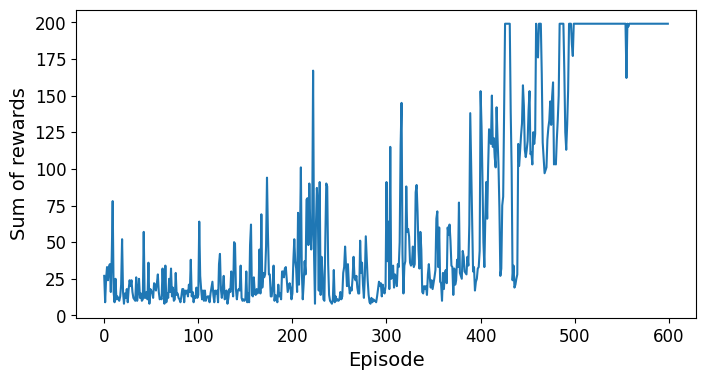

In [ ]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt

from collections import deque
from tqdm import tqdm

import gym

input_shape = [4]     # env.observation_space.shape, the same as (4,)
n_outputs = 2         # env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

#####
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())
#####

env = gym.make("CartPole-v1", new_step_api=True)
replay_memory = deque(maxlen=2000)   # double-ended queue

def epsilon_greedy_policy(state, epsilon=0):  # default greedy
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)
        return np.argmax(Q_values[0])

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

#def play_one_step(state, epsilon):
#    action = epsilon_greedy_policy(state, epsilon)
#    next_state, reward, done, info, _ = env.step(action)
#    replay_memory.append((state, action, reward, next_state, done))
#    return next_state, reward, done, info

batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    #####
    # next_Q_values = model.predict(next_states)
    next_Q_values = target.predict(next_states, verbose=0)   ###
    #####
    max_next_Q_values = next_Q_values.max(axis=1)

    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)  ###
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

# takes 36 min to train with 600 episodes in Colab

for episode in tqdm(range(600)):
    state = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)    # go from 1 down to 0.01

        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, info, _ = env.step(action)
        replay_memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            break

    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")

    if episode > 50:
        training_step(batch_size)

        #####
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
        #####

model.set_weights(best_weights)


plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

# Double DQN (DDQN)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_outputs = 2
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=6e-3)
# loss_fn = keras.losses.Huber()
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    #####
    next_Q_values = model.predict(next_states, verbose=0)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    #####
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
replay_memory = deque(maxlen=2000)

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in tqdm(range(600)):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode >= 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 55ms/step


  1%|          | 7/600 [00:00<00:11, 51.11it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 14/600 [00:00<00:10, 54.85it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 20/600 [00:00<00:20, 27.77it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 24/600 [00:00<00:19, 29.84it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 28/600 [00:00<00:20, 27.41it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 32/600 [00:01<00:28, 19.86it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 35/600 [00:01<00:49, 11.32it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 37/600 [00:02<00:52, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 40/600 [00:02<00:42, 13.03it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 42/600 [00:02<00:40, 13.70it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 44/600 [00:02<00:39, 14.24it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 46/600 [00:03<01:20,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 48/600 [00:03<01:35,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 50/600 [00:03<01:17,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 52/600 [00:04<02:09,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 53/600 [00:05<02:27,  3.72it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 54/600 [00:05<02:28,  3.68it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 55/600 [00:05<02:40,  3.39it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 56/600 [00:06<02:37,  3.46it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 57/600 [00:06<02:50,  3.19it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 58/600 [00:06<02:21,  3.82it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 59/600 [00:06<02:23,  3.76it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 60/600 [00:07<02:01,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 61/600 [00:07<02:11,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 62/600 [00:07<02:11,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 63/600 [00:07<02:16,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 64/600 [00:08<02:12,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 65/600 [00:08<02:18,  3.85it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 66/600 [00:08<02:39,  3.35it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 67/600 [00:08<02:09,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 68/600 [00:09<02:06,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 69/600 [00:09<02:13,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 70/600 [00:09<02:36,  3.39it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 71/600 [00:09<02:23,  3.68it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 72/600 [00:10<02:24,  3.66it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 73/600 [00:10<02:15,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 74/600 [00:10<01:54,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▎        | 75/600 [00:10<01:47,  4.89it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 76/600 [00:11<01:49,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 77/600 [00:11<02:26,  3.58it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 78/600 [00:12<03:20,  2.60it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 79/600 [00:12<03:04,  2.82it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 80/600 [00:12<02:51,  3.02it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 81/600 [00:12<02:43,  3.18it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 82/600 [00:13<02:38,  3.27it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 83/600 [00:13<02:33,  3.38it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 84/600 [00:13<02:39,  3.24it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 85/600 [00:14<02:48,  3.06it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 86/600 [00:14<02:47,  3.06it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 87/600 [00:15<04:01,  2.12it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 88/600 [00:15<03:23,  2.52it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 89/600 [00:15<03:12,  2.66it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 90/600 [00:16<02:40,  3.17it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 91/600 [00:16<02:17,  3.69it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 92/600 [00:16<02:04,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 93/600 [00:16<01:52,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 94/600 [00:16<02:00,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 95/600 [00:17<01:58,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 96/600 [00:17<02:12,  3.79it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 97/600 [00:17<02:46,  3.02it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 98/600 [00:18<03:01,  2.76it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 99/600 [00:18<03:12,  2.61it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 100/600 [00:19<02:55,  2.85it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 101/600 [00:19<02:44,  3.04it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 102/600 [00:19<03:00,  2.76it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 103/600 [00:20<03:11,  2.59it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 104/600 [00:20<02:48,  2.95it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 105/600 [00:20<02:47,  2.96it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 106/600 [00:21<02:37,  3.13it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 107/600 [00:21<03:53,  2.11it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 108/600 [00:22<04:07,  1.99it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 109/600 [00:22<03:34,  2.29it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 110/600 [00:23<03:16,  2.49it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 111/600 [00:23<04:06,  1.99it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 112/600 [00:23<03:15,  2.50it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 113/600 [00:24<02:52,  2.83it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 114/600 [00:24<02:24,  3.37it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 115/600 [00:24<02:52,  2.82it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 116/600 [00:25<02:47,  2.89it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 117/600 [00:25<02:36,  3.08it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 118/600 [00:25<02:43,  2.95it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 119/600 [00:26<02:40,  2.99it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 120/600 [00:26<02:31,  3.16it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 121/600 [00:26<02:20,  3.42it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 122/600 [00:27<02:34,  3.10it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 123/600 [00:27<02:26,  3.26it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 124/600 [00:27<02:20,  3.38it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 125/600 [00:27<02:30,  3.15it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 126/600 [00:28<02:44,  2.89it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 127/600 [00:28<02:25,  3.25it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 128/600 [00:28<02:11,  3.58it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 129/600 [00:29<02:38,  2.96it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 130/600 [00:29<02:51,  2.74it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 131/600 [00:30<03:00,  2.60it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 132/600 [00:30<03:21,  2.32it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 133/600 [00:31<03:18,  2.35it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 134/600 [00:31<03:10,  2.45it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▎       | 135/600 [00:31<03:13,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 136/600 [00:32<03:30,  2.21it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 137/600 [00:32<03:15,  2.37it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 138/600 [00:32<02:48,  2.75it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 139/600 [00:33<02:22,  3.23it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 140/600 [00:33<02:11,  3.51it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 141/600 [00:33<02:23,  3.20it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 142/600 [00:34<02:31,  3.02it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 143/600 [00:34<02:38,  2.89it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 144/600 [00:35<04:40,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 145/600 [00:36<04:06,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 146/600 [00:36<03:45,  2.01it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 147/600 [00:36<03:36,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 148/600 [00:37<04:26,  1.70it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 149/600 [00:38<03:56,  1.91it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 150/600 [00:38<03:41,  2.03it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 151/600 [00:39<03:36,  2.08it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 152/600 [00:39<03:11,  2.34it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 153/600 [00:39<03:21,  2.22it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 154/600 [00:40<03:06,  2.39it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 155/600 [00:40<03:01,  2.45it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 156/600 [00:41<03:14,  2.28it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 157/600 [00:41<03:07,  2.36it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 158/600 [00:41<03:01,  2.43it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 159/600 [00:42<02:48,  2.61it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 160/600 [00:42<03:01,  2.42it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 161/600 [00:42<02:43,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 162/600 [00:43<02:45,  2.65it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 163/600 [00:43<02:46,  2.62it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 164/600 [00:44<02:41,  2.71it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 165/600 [00:44<02:52,  2.52it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 166/600 [00:45<03:02,  2.38it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 167/600 [00:45<03:13,  2.24it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 168/600 [00:45<03:03,  2.35it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 169/600 [00:46<03:12,  2.24it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 170/600 [00:46<02:49,  2.54it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 171/600 [00:46<02:27,  2.91it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 172/600 [00:47<02:31,  2.82it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 173/600 [00:47<02:59,  2.38it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 174/600 [00:48<02:54,  2.44it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 175/600 [00:48<02:56,  2.41it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 176/600 [00:48<02:45,  2.56it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 177/600 [00:49<03:08,  2.24it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 178/600 [00:50<04:30,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 179/600 [00:51<04:30,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 180/600 [00:51<03:29,  2.00it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 181/600 [00:51<03:20,  2.09it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 182/600 [00:52<03:00,  2.32it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 183/600 [00:52<02:41,  2.58it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 184/600 [00:52<02:20,  2.95it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 185/600 [00:53<02:32,  2.73it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 186/600 [00:53<03:06,  2.22it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 187/600 [00:54<02:44,  2.51it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 188/600 [00:54<03:04,  2.24it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 189/600 [00:55<03:03,  2.24it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 190/600 [00:55<02:34,  2.65it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 191/600 [00:55<02:47,  2.45it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 192/600 [00:56<02:41,  2.52it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 193/600 [00:56<02:44,  2.48it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 194/600 [00:56<02:41,  2.52it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▎      | 195/600 [00:57<02:24,  2.80it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 196/600 [00:57<03:02,  2.21it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 197/600 [00:58<03:18,  2.03it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 198/600 [00:58<03:04,  2.18it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 199/600 [00:59<02:40,  2.50it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 200/600 [00:59<02:56,  2.27it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 201/600 [01:00<03:07,  2.12it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 202/600 [01:00<03:16,  2.03it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 203/600 [01:01<03:19,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 204/600 [01:01<03:16,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 205/600 [01:02<02:49,  2.33it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 206/600 [01:02<02:31,  2.60it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 207/600 [01:02<02:34,  2.54it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 208/600 [01:03<02:58,  2.20it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 209/600 [01:03<02:28,  2.63it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 210/600 [01:03<02:15,  2.88it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 211/600 [01:04<02:05,  3.10it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 212/600 [01:04<02:05,  3.08it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 213/600 [01:04<02:17,  2.81it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 214/600 [01:05<02:27,  2.62it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 215/600 [01:05<02:23,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 216/600 [01:06<02:26,  2.62it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 217/600 [01:06<02:32,  2.51it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 218/600 [01:06<02:17,  2.78it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 219/600 [01:07<02:26,  2.61it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 220/600 [01:07<02:42,  2.34it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 221/600 [01:08<02:33,  2.47it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 222/600 [01:08<02:51,  2.20it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 223/600 [01:09<02:55,  2.14it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 224/600 [01:09<02:27,  2.54it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 225/600 [01:09<02:35,  2.41it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 226/600 [01:10<02:44,  2.27it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 227/600 [01:10<02:33,  2.43it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 228/600 [01:11<02:56,  2.11it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 229/600 [01:11<02:28,  2.51it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 230/600 [01:11<02:38,  2.33it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 231/600 [01:12<02:59,  2.05it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 232/600 [01:13<02:49,  2.17it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 233/600 [01:13<02:58,  2.05it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 234/600 [01:14<03:09,  1.93it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 235/600 [01:14<03:00,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 236/600 [01:15<03:00,  2.02it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 237/600 [01:15<03:10,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 238/600 [01:16<03:02,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 239/600 [01:16<03:30,  1.71it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 240/600 [01:17<03:48,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 241/600 [01:18<04:54,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 242/600 [01:19<04:40,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 243/600 [01:21<06:53,  1.16s/it]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 244/600 [01:22<05:34,  1.06it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 245/600 [01:22<05:26,  1.09it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 246/600 [01:23<05:08,  1.15it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 247/600 [01:25<06:30,  1.10s/it]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 248/600 [01:26<05:46,  1.01it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 249/600 [01:27<05:52,  1.01s/it]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 250/600 [01:27<05:32,  1.05it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 251/600 [01:29<06:36,  1.14s/it]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 252/600 [01:30<06:07,  1.06s/it]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 253/600 [01:31<05:57,  1.03s/it]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 254/600 [01:32<06:45,  1.17s/it]

1/1 [==============================] - 0s 16ms/step


 42%|████▎     | 255/600 [01:33<05:55,  1.03s/it]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 256/600 [01:34<05:43,  1.00it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 257/600 [01:36<06:57,  1.22s/it]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 258/600 [01:36<05:59,  1.05s/it]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 259/600 [01:37<05:40,  1.00it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 260/600 [01:38<05:33,  1.02it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 261/600 [01:39<05:31,  1.02it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 262/600 [01:40<04:45,  1.18it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 263/600 [01:41<04:49,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 264/600 [01:41<04:26,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 265/600 [01:42<03:39,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 266/600 [01:43<04:19,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 267/600 [01:43<04:15,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 268/600 [01:44<04:49,  1.15it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 269/600 [01:45<04:57,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 270/600 [01:46<04:21,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 271/600 [01:47<04:47,  1.15it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 272/600 [01:48<04:44,  1.15it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 273/600 [01:48<04:12,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 274/600 [01:50<05:41,  1.05s/it]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 275/600 [01:51<05:28,  1.01s/it]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 276/600 [01:52<05:21,  1.01it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 277/600 [01:53<05:23,  1.00s/it]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 278/600 [01:54<05:04,  1.06it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 279/600 [01:55<04:47,  1.12it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 280/600 [01:55<04:05,  1.30it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 281/600 [01:56<03:49,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 282/600 [01:58<05:31,  1.04s/it]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 283/600 [01:58<04:41,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 284/600 [01:59<04:40,  1.13it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 285/600 [02:00<05:04,  1.03it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 286/600 [02:01<04:47,  1.09it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 287/600 [02:01<04:00,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 288/600 [02:03<04:56,  1.05it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 289/600 [02:05<06:29,  1.25s/it]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 290/600 [02:05<05:52,  1.14s/it]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 291/600 [02:06<05:28,  1.06s/it]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 292/600 [02:08<05:45,  1.12s/it]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 293/600 [02:09<05:21,  1.05s/it]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 294/600 [02:10<05:35,  1.09s/it]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 295/600 [02:12<06:57,  1.37s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 296/600 [02:15<09:08,  1.80s/it]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 297/600 [02:16<07:59,  1.58s/it]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 298/600 [02:17<07:38,  1.52s/it]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 299/600 [02:18<06:48,  1.36s/it]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 300/600 [02:19<06:25,  1.29s/it]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 301/600 [02:20<05:44,  1.15s/it]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 302/600 [02:21<04:56,  1.00it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 303/600 [02:22<05:44,  1.16s/it]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 304/600 [02:23<05:26,  1.10s/it]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 305/600 [02:24<05:02,  1.03s/it]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 306/600 [02:25<04:42,  1.04it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 307/600 [02:26<04:55,  1.01s/it]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 308/600 [02:27<04:41,  1.04it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 309/600 [02:28<04:34,  1.06it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 310/600 [02:29<05:30,  1.14s/it]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 311/600 [02:30<05:26,  1.13s/it]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 312/600 [02:31<05:23,  1.12s/it]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 313/600 [02:32<04:59,  1.04s/it]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 314/600 [02:34<05:32,  1.16s/it]

1/1 [==============================] - 0s 15ms/step


 52%|█████▎    | 315/600 [02:35<05:03,  1.06s/it]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 316/600 [02:35<04:47,  1.01s/it]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 317/600 [02:37<06:04,  1.29s/it]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 318/600 [02:38<05:20,  1.14s/it]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 319/600 [02:40<06:27,  1.38s/it]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 320/600 [02:42<07:28,  1.60s/it]

1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 321/600 [02:44<07:58,  1.72s/it]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 322/600 [02:47<09:26,  2.04s/it]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 323/600 [02:48<08:09,  1.77s/it]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 324/600 [02:49<06:41,  1.45s/it]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 325/600 [02:50<06:16,  1.37s/it]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 326/600 [02:51<05:36,  1.23s/it]

1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 327/600 [02:55<09:04,  1.99s/it]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 328/600 [02:56<08:07,  1.79s/it]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 329/600 [02:57<06:52,  1.52s/it]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 330/600 [02:59<06:59,  1.55s/it]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 331/600 [03:00<06:50,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 332/600 [03:02<07:59,  1.79s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 333/600 [03:04<07:18,  1.64s/it]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 334/600 [03:05<06:41,  1.51s/it]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 335/600 [03:06<06:13,  1.41s/it]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 336/600 [03:07<05:45,  1.31s/it]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 337/600 [03:08<05:35,  1.28s/it]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 338/600 [03:09<05:20,  1.22s/it]

1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 339/600 [03:11<05:46,  1.33s/it]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 340/600 [03:12<05:00,  1.16s/it]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 341/600 [03:13<04:43,  1.09s/it]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 342/600 [03:14<04:58,  1.16s/it]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 343/600 [03:16<05:33,  1.30s/it]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 344/600 [03:17<05:23,  1.26s/it]

1/1 [==============================] - 0s 16ms/step


 57%|█████▊    | 345/600 [03:18<05:16,  1.24s/it]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 346/600 [03:19<04:46,  1.13s/it]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 347/600 [03:20<04:25,  1.05s/it]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 348/600 [03:21<04:40,  1.11s/it]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 349/600 [03:22<04:22,  1.05s/it]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 350/600 [03:23<03:52,  1.07it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 351/600 [03:23<03:43,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 352/600 [03:24<03:25,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 353/600 [03:25<03:38,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 354/600 [03:26<03:15,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 355/600 [03:27<03:31,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 356/600 [03:27<03:15,  1.25it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 357/600 [03:28<02:58,  1.36it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 358/600 [03:29<03:30,  1.15it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 359/600 [03:30<03:31,  1.14it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 360/600 [03:31<03:48,  1.05it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 361/600 [03:32<03:31,  1.13it/s]

1/1 [==============================] - 0s 15ms/step


 60%|██████    | 362/600 [03:33<04:03,  1.02s/it]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 363/600 [03:35<05:14,  1.33s/it]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 364/600 [03:36<04:58,  1.26s/it]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 365/600 [03:38<05:32,  1.41s/it]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 366/600 [03:39<04:48,  1.23s/it]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 367/600 [03:40<04:59,  1.29s/it]

1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 368/600 [03:42<05:45,  1.49s/it]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 369/600 [03:44<05:44,  1.49s/it]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 370/600 [03:46<06:01,  1.57s/it]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 371/600 [03:47<06:13,  1.63s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 372/600 [03:50<07:24,  1.95s/it]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 373/600 [03:53<08:11,  2.17s/it]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 374/600 [03:54<07:17,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


 62%|██████▎   | 375/600 [03:57<07:53,  2.11s/it]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 376/600 [03:58<07:06,  1.90s/it]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 377/600 [03:59<06:11,  1.67s/it]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 378/600 [04:01<06:05,  1.65s/it]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 379/600 [04:01<05:03,  1.38s/it]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 380/600 [04:03<04:42,  1.28s/it]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 381/600 [04:03<04:10,  1.14s/it]

1/1 [==============================] - 0s 15ms/step


 64%|██████▎   | 382/600 [04:04<03:48,  1.05s/it]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 383/600 [04:05<03:50,  1.06s/it]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 384/600 [04:06<03:57,  1.10s/it]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 385/600 [04:07<03:30,  1.02it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 386/600 [04:08<03:39,  1.03s/it]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 387/600 [04:09<03:35,  1.01s/it]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 388/600 [04:11<03:54,  1.10s/it]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 389/600 [04:13<04:45,  1.35s/it]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 390/600 [04:14<04:27,  1.27s/it]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 391/600 [04:15<04:22,  1.26s/it]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 392/600 [04:16<03:57,  1.14s/it]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 393/600 [04:17<04:11,  1.21s/it]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 394/600 [04:18<04:02,  1.18s/it]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 395/600 [04:20<04:29,  1.31s/it]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 396/600 [04:20<03:40,  1.08s/it]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 397/600 [04:21<03:22,  1.00it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 398/600 [04:22<02:48,  1.20it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▋   | 399/600 [04:22<02:43,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 400/600 [04:23<02:22,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 401/600 [04:24<02:20,  1.41it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 402/600 [04:25<02:38,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 403/600 [04:25<02:21,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 404/600 [04:26<02:54,  1.13it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 405/600 [04:27<02:46,  1.17it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 406/600 [04:28<02:50,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 407/600 [04:30<04:11,  1.30s/it]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 408/600 [04:31<03:54,  1.22s/it]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 409/600 [04:32<03:24,  1.07s/it]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 410/600 [04:33<03:15,  1.03s/it]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 411/600 [04:34<02:58,  1.06it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 412/600 [04:35<02:47,  1.12it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 413/600 [04:35<02:38,  1.18it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 414/600 [04:36<02:23,  1.30it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 415/600 [04:37<02:20,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 416/600 [04:37<02:11,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 417/600 [04:38<02:19,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 418/600 [04:39<02:14,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 419/600 [04:39<02:07,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 420/600 [04:40<02:01,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 421/600 [04:41<02:06,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 422/600 [04:42<02:10,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 423/600 [04:42<02:04,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 424/600 [04:43<02:02,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 425/600 [04:44<02:00,  1.46it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 426/600 [04:44<02:02,  1.42it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 427/600 [04:45<02:03,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 428/600 [04:46<02:01,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 429/600 [04:47<02:14,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 430/600 [04:47<02:08,  1.32it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 431/600 [04:48<02:03,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 432/600 [04:49<02:21,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 433/600 [04:50<02:25,  1.14it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 434/600 [04:51<02:21,  1.17it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▎  | 435/600 [04:52<02:34,  1.07it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 436/600 [04:54<03:28,  1.27s/it]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 437/600 [04:55<03:22,  1.24s/it]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 438/600 [04:57<03:31,  1.31s/it]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 439/600 [05:00<04:41,  1.75s/it]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 440/600 [05:01<04:13,  1.59s/it]

1/1 [==============================] - 0s 15ms/step


 74%|███████▎  | 441/600 [05:02<03:56,  1.49s/it]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 442/600 [05:05<04:57,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 443/600 [05:07<05:03,  1.93s/it]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 444/600 [05:09<05:11,  2.00s/it]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 445/600 [05:10<04:44,  1.84s/it]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 446/600 [05:12<04:11,  1.63s/it]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 447/600 [05:13<03:57,  1.55s/it]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 448/600 [05:14<03:44,  1.48s/it]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 449/600 [05:17<04:16,  1.70s/it]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 450/600 [05:18<03:51,  1.54s/it]

1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 451/600 [05:19<03:39,  1.48s/it]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 452/600 [05:20<03:20,  1.35s/it]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 453/600 [05:21<03:04,  1.25s/it]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 454/600 [05:23<03:09,  1.30s/it]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 455/600 [05:24<02:58,  1.23s/it]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 456/600 [05:25<03:03,  1.28s/it]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 457/600 [05:26<02:52,  1.21s/it]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 458/600 [05:28<03:29,  1.48s/it]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 459/600 [05:29<03:23,  1.45s/it]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 460/600 [05:33<04:41,  2.01s/it]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 461/600 [05:34<04:04,  1.76s/it]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 462/600 [05:35<03:45,  1.63s/it]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 463/600 [05:37<03:34,  1.57s/it]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 464/600 [05:39<04:04,  1.79s/it]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 465/600 [05:40<03:36,  1.60s/it]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 466/600 [05:41<03:18,  1.48s/it]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 467/600 [05:43<03:05,  1.40s/it]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 468/600 [05:44<03:12,  1.46s/it]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 469/600 [05:45<02:48,  1.29s/it]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 470/600 [05:46<02:39,  1.23s/it]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 471/600 [05:47<02:22,  1.11s/it]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 472/600 [05:49<02:39,  1.24s/it]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 473/600 [05:50<02:38,  1.25s/it]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 474/600 [05:51<02:39,  1.27s/it]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 475/600 [05:53<02:52,  1.38s/it]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 476/600 [05:54<02:34,  1.25s/it]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 477/600 [05:55<02:32,  1.24s/it]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 478/600 [05:57<02:44,  1.35s/it]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 479/600 [05:58<02:44,  1.36s/it]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 480/600 [05:59<02:34,  1.29s/it]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 481/600 [06:01<02:50,  1.43s/it]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 482/600 [06:03<03:12,  1.63s/it]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 483/600 [06:04<03:06,  1.60s/it]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 484/600 [06:06<03:04,  1.59s/it]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 485/600 [06:09<03:36,  1.88s/it]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 486/600 [06:11<03:44,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 487/600 [06:13<03:49,  2.03s/it]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 488/600 [06:14<03:31,  1.89s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 489/600 [06:17<03:41,  1.99s/it]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 490/600 [06:21<04:55,  2.69s/it]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 491/600 [06:23<04:28,  2.46s/it]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 492/600 [06:26<05:00,  2.78s/it]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 493/600 [06:28<04:25,  2.48s/it]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 494/600 [06:30<03:48,  2.15s/it]

1/1 [==============================] - 0s 16ms/step


 82%|████████▎ | 495/600 [06:31<03:27,  1.97s/it]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 496/600 [06:33<03:08,  1.81s/it]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 497/600 [06:34<02:43,  1.58s/it]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 498/600 [06:34<02:16,  1.33s/it]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 499/600 [06:35<02:01,  1.20s/it]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 500/600 [06:36<01:57,  1.17s/it]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 501/600 [06:38<01:55,  1.16s/it]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 502/600 [06:38<01:45,  1.08s/it]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 503/600 [06:39<01:34,  1.02it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 504/600 [06:40<01:29,  1.07it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 505/600 [06:41<01:28,  1.07it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 506/600 [06:42<01:22,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 507/600 [06:43<01:23,  1.12it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 508/600 [06:43<01:19,  1.15it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 509/600 [06:44<01:17,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 510/600 [06:45<01:16,  1.17it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 511/600 [06:46<01:21,  1.09it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 512/600 [06:47<01:17,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 513/600 [06:48<01:19,  1.10it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 514/600 [06:49<01:17,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 515/600 [06:50<01:12,  1.17it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 516/600 [06:50<01:11,  1.18it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 517/600 [06:51<01:14,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 518/600 [06:53<01:19,  1.04it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 519/600 [06:53<01:16,  1.06it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 520/600 [06:54<01:13,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 521/600 [06:55<01:14,  1.06it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 522/600 [06:56<01:11,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 523/600 [06:57<01:09,  1.10it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 524/600 [06:58<01:12,  1.05it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 525/600 [06:59<01:08,  1.10it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 526/600 [07:00<01:10,  1.05it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 527/600 [07:01<01:19,  1.09s/it]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 528/600 [07:03<01:20,  1.12s/it]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 529/600 [07:03<01:14,  1.05s/it]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 530/600 [07:04<01:11,  1.01s/it]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 531/600 [07:06<01:11,  1.04s/it]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 532/600 [07:07<01:16,  1.12s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 533/600 [07:09<01:32,  1.38s/it]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 534/600 [07:11<01:47,  1.63s/it]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 535/600 [07:16<02:59,  2.76s/it]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 536/600 [07:21<03:28,  3.25s/it]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 537/600 [07:22<02:53,  2.75s/it]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 538/600 [07:24<02:34,  2.49s/it]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 539/600 [07:27<02:32,  2.50s/it]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 540/600 [07:28<02:14,  2.24s/it]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 541/600 [07:30<02:00,  2.04s/it]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 542/600 [07:35<02:51,  2.95s/it]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 543/600 [07:37<02:25,  2.56s/it]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 544/600 [07:38<02:05,  2.25s/it]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 545/600 [07:40<01:55,  2.09s/it]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 546/600 [07:43<02:03,  2.29s/it]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 547/600 [07:45<01:53,  2.15s/it]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 548/600 [07:46<01:39,  1.92s/it]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 549/600 [07:47<01:27,  1.72s/it]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 550/600 [07:48<01:15,  1.50s/it]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 551/600 [07:51<01:26,  1.76s/it]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 552/600 [07:52<01:18,  1.64s/it]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 553/600 [07:53<01:15,  1.60s/it]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 554/600 [07:55<01:10,  1.53s/it]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▎| 555/600 [07:56<01:08,  1.52s/it]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 556/600 [07:57<00:58,  1.34s/it]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 557/600 [07:59<00:57,  1.34s/it]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 558/600 [08:00<00:55,  1.33s/it]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/600 [08:04<01:30,  2.22s/it]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 560/600 [08:06<01:20,  2.01s/it]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 561/600 [08:07<01:12,  1.86s/it]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 562/600 [08:09<01:07,  1.77s/it]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 563/600 [08:11<01:14,  2.01s/it]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 564/600 [08:13<01:05,  1.81s/it]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 565/600 [08:16<01:15,  2.15s/it]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 566/600 [08:17<01:05,  1.93s/it]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 567/600 [08:18<00:56,  1.72s/it]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 568/600 [08:19<00:48,  1.50s/it]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 569/600 [08:20<00:41,  1.33s/it]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 570/600 [08:21<00:36,  1.20s/it]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 571/600 [08:22<00:35,  1.24s/it]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 572/600 [08:23<00:31,  1.14s/it]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 573/600 [08:24<00:28,  1.05s/it]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 574/600 [08:26<00:30,  1.17s/it]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 575/600 [08:27<00:31,  1.28s/it]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 576/600 [08:28<00:28,  1.20s/it]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 577/600 [08:29<00:27,  1.19s/it]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 578/600 [08:30<00:22,  1.02s/it]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 579/600 [08:31<00:23,  1.11s/it]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 580/600 [08:32<00:20,  1.03s/it]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 581/600 [08:33<00:19,  1.03s/it]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 582/600 [08:34<00:18,  1.05s/it]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 583/600 [08:35<00:16,  1.01it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 584/600 [08:36<00:15,  1.03it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 585/600 [08:37<00:14,  1.05it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 586/600 [08:38<00:12,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 587/600 [08:38<00:11,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 588/600 [08:40<00:11,  1.07it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 589/600 [08:40<00:10,  1.08it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 590/600 [08:41<00:08,  1.15it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 591/600 [08:42<00:07,  1.16it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 592/600 [08:43<00:07,  1.10it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 593/600 [08:44<00:06,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 594/600 [08:45<00:05,  1.06it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 595/600 [08:46<00:04,  1.01it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 596/600 [08:48<00:04,  1.15s/it]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 597/600 [08:49<00:03,  1.07s/it]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 598/600 [08:50<00:02,  1.05s/it]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 599/600 [08:50<00:01,  1.01s/it]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 600/600 [08:52<00:00,  1.13it/s]


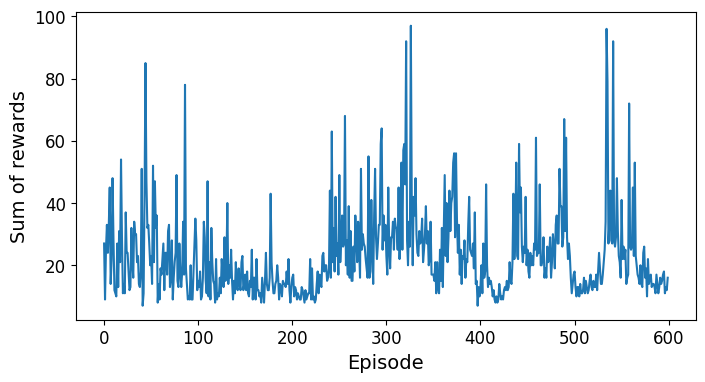

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
# save_fig("double_dqn_rewards_plot")
plt.show()

In [ ]:
env.seed(43)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

## Putting all together

  0%|          | 1/600 [00:00<02:28,  4.04it/s]

Episode: 5, Steps: 34, eps: 0.990

  2%|▏         | 11/600 [00:02<01:53,  5.17it/s]

Episode: 10, Steps: 17, eps: 0.980

  3%|▎         | 19/600 [00:02<00:53, 10.91it/s]

Episode: 18, Steps: 22, eps: 0.964

  4%|▍         | 25/600 [00:02<00:37, 15.23it/s]

Episode: 26, Steps: 24, eps: 0.948

  5%|▍         | 28/600 [00:03<00:44, 12.73it/s]

Episode: 29, Steps: 26, eps: 0.942

  6%|▌         | 33/600 [00:03<00:42, 13.48it/s]

Episode: 32, Steps: 13, eps: 0.936

  6%|▌         | 35/600 [00:03<00:48, 11.69it/s]

Episode: 35, Steps: 13, eps: 0.930

  6%|▋         | 39/600 [00:04<00:50, 11.03it/s]

Episode: 38, Steps: 20, eps: 0.924

  7%|▋         | 44/600 [00:04<00:39, 14.19it/s]

Episode: 44, Steps: 23, eps: 0.912

  8%|▊         | 47/600 [00:04<00:35, 15.65it/s]

Episode: 47, Steps: 18, eps: 0.906

  8%|▊         | 51/600 [00:04<00:37, 14.52it/s]

Episode: 51, Steps: 14, eps: 0.898

  9%|▉         | 53/600 [00:06<01:43,  5.27it/s]

Episode: 52, Steps: 31, eps: 0.896

  9%|▉         | 55/600 [00:06<01:40,  5.41it/s]

Episode: 55, Steps: 14, eps: 0.890

 10%|▉         | 57/600 [00:06<01:44,  5.19it/s]

Episode: 57, Steps: 18, eps: 0.886

 10%|▉         | 59/600 [00:07<01:39,  5.42it/s]

Episode: 59, Steps: 20, eps: 0.882

 10%|█         | 61/600 [00:07<01:47,  5.02it/s]

Episode: 61, Steps: 12, eps: 0.878

 10%|█         | 63/600 [00:08<02:27,  3.63it/s]

Episode: 62, Steps: 85, eps: 0.876

 11%|█         | 64/600 [00:08<02:28,  3.60it/s]

Episode: 64, Steps: 17, eps: 0.872

 11%|█         | 66/600 [00:08<02:00,  4.41it/s]

Episode: 66, Steps: 14, eps: 0.868

 11%|█▏        | 68/600 [00:09<01:39,  5.36it/s]

Episode: 67, Steps: 15, eps: 0.866

 12%|█▏        | 69/600 [00:09<01:54,  4.64it/s]

Episode: 68, Steps: 26, eps: 0.864

 12%|█▏        | 70/600 [00:09<02:10,  4.08it/s]

Episode: 69, Steps: 18, eps: 0.862

 12%|█▏        | 71/600 [00:10<02:23,  3.70it/s]

Episode: 71, Steps: 21, eps: 0.858

 12%|█▏        | 73/600 [00:10<01:46,  4.93it/s]

Episode: 73, Steps: 24, eps: 0.854

 13%|█▎        | 76/600 [00:10<01:18,  6.63it/s]

Episode: 75, Steps: 11, eps: 0.850

 13%|█▎        | 77/600 [00:10<01:18,  6.70it/s]

Episode: 77, Steps: 13, eps: 0.846

 13%|█▎        | 79/600 [00:11<01:52,  4.63it/s]

Episode: 78, Steps: 48, eps: 0.844

 13%|█▎        | 80/600 [00:11<01:55,  4.52it/s]

Episode: 79, Steps: 44, eps: 0.842

 14%|█▎        | 81/600 [00:12<02:30,  3.44it/s]

Episode: 80, Steps: 45, eps: 0.840

 14%|█▎        | 82/600 [00:12<02:21,  3.65it/s]

Episode: 81, Steps: 18, eps: 0.838

 14%|█▍        | 83/600 [00:12<02:23,  3.61it/s]

Episode: 83, Steps: 13, eps: 0.834

 14%|█▍        | 85/600 [00:13<02:02,  4.21it/s]

Episode: 84, Steps: 24, eps: 0.832

 14%|█▍        | 86/600 [00:13<02:02,  4.19it/s]

Episode: 86, Steps: 12, eps: 0.828

 15%|█▍        | 88/600 [00:13<01:52,  4.56it/s]

Episode: 88, Steps: 15, eps: 0.824

 15%|█▌        | 90/600 [00:14<01:59,  4.28it/s]

Episode: 89, Steps: 11, eps: 0.822

 15%|█▌        | 91/600 [00:14<02:17,  3.71it/s]

Episode: 90, Steps: 19, eps: 0.820

 15%|█▌        | 92/600 [00:14<02:12,  3.84it/s]

Episode: 91, Steps: 15, eps: 0.818

 16%|█▌        | 93/600 [00:15<02:15,  3.74it/s]

Episode: 93, Steps: 12, eps: 0.814

 16%|█▌        | 95/600 [00:15<01:51,  4.53it/s]

Episode: 95, Steps: 12, eps: 0.810

 16%|█▌        | 97/600 [00:15<01:50,  4.56it/s]

Episode: 96, Steps: 36, eps: 0.808

 16%|█▋        | 98/600 [00:16<02:01,  4.12it/s]

Episode: 97, Steps: 12, eps: 0.806

 16%|█▋        | 99/600 [00:16<02:01,  4.11it/s]

Episode: 98, Steps: 9, eps: 0.804

 17%|█▋        | 100/600 [00:16<02:21,  3.55it/s]

Episode: 99, Steps: 28, eps: 0.802

 17%|█▋        | 101/600 [00:16<02:13,  3.73it/s]

Episode: 100, Steps: 17, eps: 0.800

 17%|█▋        | 102/600 [00:17<03:04,  2.70it/s]

Episode: 101, Steps: 57, eps: 0.798

 17%|█▋        | 103/600 [00:17<02:43,  3.04it/s]

Episode: 102, Steps: 12, eps: 0.796

 17%|█▋        | 104/600 [00:18<02:44,  3.01it/s]

Episode: 104, Steps: 17, eps: 0.792

 18%|█▊        | 106/600 [00:18<02:29,  3.30it/s]

Episode: 105, Steps: 27, eps: 0.790

 18%|█▊        | 107/600 [00:18<02:20,  3.51it/s]

Episode: 106, Steps: 15, eps: 0.788

 18%|█▊        | 108/600 [00:19<02:25,  3.38it/s]

Episode: 108, Steps: 15, eps: 0.784

 18%|█▊        | 110/600 [00:19<02:47,  2.92it/s]

Episode: 109, Steps: 23, eps: 0.782

 18%|█▊        | 111/600 [00:20<02:59,  2.72it/s]

Episode: 111, Steps: 16, eps: 0.778

 19%|█▉        | 113/600 [00:20<02:17,  3.54it/s]

Episode: 112, Steps: 15, eps: 0.776

 19%|█▉        | 114/600 [00:21<02:25,  3.35it/s]

Episode: 113, Steps: 15, eps: 0.774

 19%|█▉        | 115/600 [00:21<02:37,  3.07it/s]

Episode: 114, Steps: 24, eps: 0.772

 19%|█▉        | 116/600 [00:21<02:24,  3.36it/s]

Episode: 115, Steps: 18, eps: 0.770

 20%|█▉        | 117/600 [00:22<02:35,  3.10it/s]

Episode: 117, Steps: 11, eps: 0.766

 20%|█▉        | 119/600 [00:22<02:44,  2.93it/s]

Episode: 119, Steps: 15, eps: 0.762

 20%|██        | 121/600 [00:23<02:00,  3.97it/s]

Episode: 121, Steps: 14, eps: 0.758

 20%|██        | 123/600 [00:23<01:45,  4.50it/s]

Episode: 123, Steps: 13, eps: 0.754

 21%|██        | 125/600 [00:24<02:00,  3.96it/s]

Episode: 124, Steps: 23, eps: 0.752

 21%|██        | 126/600 [00:24<02:11,  3.61it/s]

Episode: 126, Steps: 20, eps: 0.748

 21%|██▏       | 128/600 [00:25<03:13,  2.44it/s]

Episode: 127, Steps: 19, eps: 0.746

 22%|██▏       | 129/600 [00:25<02:57,  2.65it/s]

Episode: 128, Steps: 16, eps: 0.744

 22%|██▏       | 130/600 [00:26<02:57,  2.65it/s]

Episode: 129, Steps: 13, eps: 0.742

 22%|██▏       | 131/600 [00:27<03:55,  1.99it/s]

Episode: 130, Steps: 61, eps: 0.740

 22%|██▏       | 132/600 [00:27<03:27,  2.26it/s]

Episode: 131, Steps: 11, eps: 0.738

 22%|██▏       | 133/600 [00:27<02:57,  2.62it/s]

Episode: 132, Steps: 23, eps: 0.736

 22%|██▏       | 134/600 [00:27<02:52,  2.71it/s]

Episode: 133, Steps: 23, eps: 0.734

 22%|██▎       | 135/600 [00:28<03:26,  2.25it/s]

Episode: 134, Steps: 30, eps: 0.732

 23%|██▎       | 136/600 [00:28<03:21,  2.30it/s]

Episode: 135, Steps: 13, eps: 0.730

 23%|██▎       | 137/600 [00:29<02:59,  2.59it/s]

Episode: 136, Steps: 16, eps: 0.728

 23%|██▎       | 138/600 [00:29<02:38,  2.92it/s]

Episode: 137, Steps: 15, eps: 0.726

 23%|██▎       | 139/600 [00:30<03:44,  2.06it/s]

Episode: 138, Steps: 53, eps: 0.724

 23%|██▎       | 140/600 [00:30<03:14,  2.37it/s]

Episode: 139, Steps: 13, eps: 0.722

 24%|██▎       | 141/600 [00:31<03:32,  2.16it/s]

Episode: 140, Steps: 23, eps: 0.720

 24%|██▎       | 142/600 [00:31<03:43,  2.05it/s]

Episode: 141, Steps: 26, eps: 0.718

 24%|██▍       | 143/600 [00:32<03:45,  2.03it/s]

Episode: 142, Steps: 43, eps: 0.716

 24%|██▍       | 144/600 [00:32<03:19,  2.29it/s]

Episode: 143, Steps: 14, eps: 0.714

 24%|██▍       | 145/600 [00:33<04:28,  1.70it/s]

Episode: 144, Steps: 57, eps: 0.712

 24%|██▍       | 146/600 [00:33<03:57,  1.91it/s]

Episode: 145, Steps: 16, eps: 0.710

 24%|██▍       | 147/600 [00:34<03:53,  1.94it/s]

Episode: 146, Steps: 23, eps: 0.708

 25%|██▍       | 148/600 [00:34<03:15,  2.31it/s]

Episode: 147, Steps: 13, eps: 0.706

 25%|██▍       | 149/600 [00:34<03:06,  2.41it/s]

Episode: 148, Steps: 11, eps: 0.704

 25%|██▌       | 150/600 [00:35<03:01,  2.48it/s]

Episode: 149, Steps: 11, eps: 0.702

 25%|██▌       | 151/600 [00:35<03:38,  2.06it/s]

Episode: 150, Steps: 24, eps: 0.700

 25%|██▌       | 152/600 [00:36<03:13,  2.32it/s]

Episode: 151, Steps: 10, eps: 0.698

 26%|██▌       | 153/600 [00:36<03:12,  2.33it/s]

Episode: 152, Steps: 21, eps: 0.696

 26%|██▌       | 154/600 [00:36<02:58,  2.50it/s]

Episode: 154, Steps: 19, eps: 0.692

 26%|██▌       | 156/600 [00:37<03:00,  2.46it/s]

Episode: 155, Steps: 30, eps: 0.690

 26%|██▌       | 157/600 [00:38<02:44,  2.70it/s]

Episode: 156, Steps: 16, eps: 0.688

 26%|██▋       | 158/600 [00:38<02:44,  2.68it/s]

Episode: 157, Steps: 15, eps: 0.686

 26%|██▋       | 159/600 [00:39<03:25,  2.15it/s]

Episode: 158, Steps: 50, eps: 0.684

 27%|██▋       | 160/600 [00:39<03:13,  2.27it/s]

Episode: 159, Steps: 27, eps: 0.682

 27%|██▋       | 161/600 [00:39<03:17,  2.23it/s]

Episode: 160, Steps: 20, eps: 0.680

 27%|██▋       | 162/600 [00:40<03:13,  2.27it/s]

Episode: 161, Steps: 24, eps: 0.678

 27%|██▋       | 163/600 [00:40<02:58,  2.45it/s]

Episode: 162, Steps: 14, eps: 0.676

 27%|██▋       | 164/600 [00:41<02:54,  2.50it/s]

Episode: 163, Steps: 16, eps: 0.674

 28%|██▊       | 165/600 [00:41<03:19,  2.18it/s]

Episode: 164, Steps: 35, eps: 0.672

 28%|██▊       | 166/600 [00:42<03:20,  2.16it/s]

Episode: 165, Steps: 13, eps: 0.670

 28%|██▊       | 167/600 [00:42<03:04,  2.34it/s]

Episode: 166, Steps: 14, eps: 0.668

 28%|██▊       | 168/600 [00:43<03:18,  2.18it/s]

Episode: 167, Steps: 27, eps: 0.666

 28%|██▊       | 169/600 [00:44<05:18,  1.35it/s]

Episode: 168, Steps: 100, eps: 0.664

 28%|██▊       | 170/600 [00:44<04:55,  1.46it/s]

Episode: 169, Steps: 21, eps: 0.662

 28%|██▊       | 171/600 [00:45<04:08,  1.73it/s]

Episode: 170, Steps: 10, eps: 0.660

 29%|██▊       | 172/600 [00:45<03:31,  2.02it/s]

Episode: 171, Steps: 14, eps: 0.658

 29%|██▉       | 173/600 [00:45<03:16,  2.17it/s]

Episode: 172, Steps: 14, eps: 0.656

 29%|██▉       | 174/600 [00:46<03:04,  2.31it/s]

Episode: 173, Steps: 17, eps: 0.654

 29%|██▉       | 175/600 [00:46<02:55,  2.42it/s]

Episode: 174, Steps: 15, eps: 0.652

 29%|██▉       | 176/600 [00:47<02:42,  2.61it/s]

Episode: 175, Steps: 14, eps: 0.650

 30%|██▉       | 177/600 [00:47<02:41,  2.61it/s]

Episode: 176, Steps: 18, eps: 0.648

 30%|██▉       | 178/600 [00:47<02:48,  2.50it/s]

Episode: 177, Steps: 22, eps: 0.646

 30%|██▉       | 179/600 [00:48<04:19,  1.63it/s]

Episode: 178, Steps: 76, eps: 0.644

 30%|███       | 180/600 [00:49<05:07,  1.37it/s]

Episode: 179, Steps: 44, eps: 0.642

 30%|███       | 181/600 [00:50<04:54,  1.42it/s]

Episode: 180, Steps: 31, eps: 0.640

 30%|███       | 182/600 [00:51<04:39,  1.50it/s]

Episode: 181, Steps: 34, eps: 0.638

 30%|███       | 183/600 [00:52<05:19,  1.31it/s]

Episode: 182, Steps: 55, eps: 0.636

 31%|███       | 184/600 [00:53<05:35,  1.24it/s]

Episode: 183, Steps: 40, eps: 0.634

 31%|███       | 185/600 [00:53<05:11,  1.33it/s]

Episode: 184, Steps: 35, eps: 0.632

 31%|███       | 186/600 [00:54<04:50,  1.43it/s]

Episode: 185, Steps: 39, eps: 0.630

 31%|███       | 187/600 [00:54<04:35,  1.50it/s]

Episode: 186, Steps: 29, eps: 0.628

 31%|███▏      | 188/600 [00:55<04:25,  1.55it/s]

Episode: 187, Steps: 25, eps: 0.626

 32%|███▏      | 189/600 [00:56<04:13,  1.62it/s]

Episode: 188, Steps: 25, eps: 0.624

 32%|███▏      | 190/600 [00:57<05:28,  1.25it/s]

Episode: 189, Steps: 80, eps: 0.622

 32%|███▏      | 191/600 [00:58<05:48,  1.17it/s]

Episode: 190, Steps: 38, eps: 0.620

 32%|███▏      | 192/600 [00:58<04:49,  1.41it/s]

Episode: 191, Steps: 28, eps: 0.618

 32%|███▏      | 193/600 [00:58<04:06,  1.65it/s]

Episode: 192, Steps: 23, eps: 0.616

 32%|███▏      | 194/600 [01:00<05:50,  1.16it/s]

Episode: 193, Steps: 69, eps: 0.614

 32%|███▎      | 195/600 [01:01<05:28,  1.23it/s]

Episode: 194, Steps: 27, eps: 0.612

 33%|███▎      | 196/600 [01:02<07:18,  1.09s/it]

Episode: 195, Steps: 90, eps: 0.610

 33%|███▎      | 197/600 [01:03<07:04,  1.05s/it]

Episode: 196, Steps: 47, eps: 0.608

 33%|███▎      | 198/600 [01:05<08:04,  1.20s/it]

Episode: 197, Steps: 91, eps: 0.606

 33%|███▎      | 199/600 [01:06<07:05,  1.06s/it]

Episode: 198, Steps: 40, eps: 0.604

 33%|███▎      | 200/600 [01:06<06:01,  1.11it/s]

Episode: 199, Steps: 24, eps: 0.602

 34%|███▎      | 201/600 [01:07<05:05,  1.31it/s]

Episode: 200, Steps: 12, eps: 0.600

 34%|███▎      | 202/600 [01:07<03:56,  1.68it/s]

Episode: 201, Steps: 14, eps: 0.598

 34%|███▍      | 203/600 [01:07<03:45,  1.76it/s]

Episode: 202, Steps: 24, eps: 0.596

 34%|███▍      | 204/600 [01:08<03:18,  1.99it/s]

Episode: 204, Steps: 13, eps: 0.592

 34%|███▍      | 206/600 [01:09<03:27,  1.90it/s]

Episode: 205, Steps: 14, eps: 0.590

 34%|███▍      | 207/600 [01:09<03:20,  1.96it/s]

Episode: 206, Steps: 17, eps: 0.588

 35%|███▍      | 208/600 [01:10<03:12,  2.04it/s]

Episode: 207, Steps: 16, eps: 0.586

 35%|███▍      | 209/600 [01:10<03:03,  2.13it/s]

Episode: 208, Steps: 16, eps: 0.584

 35%|███▌      | 210/600 [01:12<05:08,  1.26it/s]

Episode: 209, Steps: 40, eps: 0.582

 35%|███▌      | 211/600 [01:12<04:16,  1.51it/s]

Episode: 210, Steps: 15, eps: 0.580

 35%|███▌      | 212/600 [01:12<03:45,  1.72it/s]

Episode: 211, Steps: 10, eps: 0.578

 36%|███▌      | 213/600 [01:13<03:06,  2.08it/s]

Episode: 212, Steps: 13, eps: 0.576

 36%|███▌      | 214/600 [01:13<03:10,  2.03it/s]

Episode: 213, Steps: 15, eps: 0.574

 36%|███▌      | 215/600 [01:14<03:07,  2.06it/s]

Episode: 214, Steps: 14, eps: 0.572

 36%|███▌      | 216/600 [01:14<03:24,  1.88it/s]

Episode: 215, Steps: 30, eps: 0.570

 36%|███▌      | 217/600 [01:16<05:02,  1.27it/s]

Episode: 216, Steps: 64, eps: 0.568

 36%|███▋      | 218/600 [01:17<05:09,  1.24it/s]

Episode: 217, Steps: 28, eps: 0.566

 36%|███▋      | 219/600 [01:17<04:53,  1.30it/s]

Episode: 218, Steps: 27, eps: 0.564

 37%|███▋      | 220/600 [01:18<05:06,  1.24it/s]

Episode: 219, Steps: 37, eps: 0.562

 37%|███▋      | 221/600 [01:19<04:59,  1.26it/s]

Episode: 220, Steps: 28, eps: 0.560

 37%|███▋      | 222/600 [01:20<05:21,  1.18it/s]

Episode: 221, Steps: 35, eps: 0.558

 37%|███▋      | 223/600 [01:20<04:49,  1.30it/s]

Episode: 222, Steps: 20, eps: 0.556

 37%|███▋      | 224/600 [01:21<03:48,  1.64it/s]

Episode: 223, Steps: 11, eps: 0.554

 38%|███▊      | 225/600 [01:21<03:28,  1.79it/s]

Episode: 224, Steps: 13, eps: 0.552

 38%|███▊      | 226/600 [01:22<03:35,  1.74it/s]

Episode: 225, Steps: 21, eps: 0.550

 38%|███▊      | 227/600 [01:22<03:13,  1.93it/s]

Episode: 226, Steps: 14, eps: 0.548

 38%|███▊      | 228/600 [01:23<03:08,  1.97it/s]

Episode: 227, Steps: 10, eps: 0.546

 38%|███▊      | 229/600 [01:23<02:42,  2.28it/s]

Episode: 228, Steps: 9, eps: 0.544

 38%|███▊      | 230/600 [01:23<02:35,  2.39it/s]

Episode: 229, Steps: 15, eps: 0.542

 38%|███▊      | 231/600 [01:24<02:35,  2.37it/s]

Episode: 230, Steps: 15, eps: 0.540

 39%|███▊      | 232/600 [01:24<02:39,  2.31it/s]

Episode: 231, Steps: 17, eps: 0.538

 39%|███▉      | 233/600 [01:25<02:58,  2.06it/s]

Episode: 232, Steps: 20, eps: 0.536

 39%|███▉      | 234/600 [01:26<04:18,  1.41it/s]

Episode: 233, Steps: 58, eps: 0.534

 39%|███▉      | 235/600 [01:27<04:35,  1.32it/s]

Episode: 234, Steps: 36, eps: 0.532

 39%|███▉      | 236/600 [01:28<04:32,  1.34it/s]

Episode: 235, Steps: 38, eps: 0.530

 40%|███▉      | 237/600 [01:29<06:25,  1.06s/it]

Episode: 236, Steps: 77, eps: 0.528

 40%|███▉      | 238/600 [01:31<06:44,  1.12s/it]

Episode: 237, Steps: 48, eps: 0.526

 40%|███▉      | 239/600 [01:32<07:57,  1.32s/it]

Episode: 238, Steps: 81, eps: 0.524

 40%|████      | 240/600 [01:34<08:01,  1.34s/it]

Episode: 239, Steps: 57, eps: 0.522

 40%|████      | 241/600 [01:34<06:19,  1.06s/it]

Episode: 240, Steps: 17, eps: 0.520

 40%|████      | 242/600 [01:36<08:16,  1.39s/it]

Episode: 241, Steps: 90, eps: 0.518

 40%|████      | 243/600 [01:38<08:36,  1.45s/it]

Episode: 242, Steps: 74, eps: 0.516

 41%|████      | 244/600 [01:38<06:55,  1.17s/it]

Episode: 243, Steps: 20, eps: 0.514

 41%|████      | 245/600 [01:39<06:16,  1.06s/it]

Episode: 244, Steps: 35, eps: 0.512

 41%|████      | 246/600 [01:40<05:33,  1.06it/s]

Episode: 245, Steps: 20, eps: 0.510

 41%|████      | 247/600 [01:41<05:14,  1.12it/s]

Episode: 246, Steps: 26, eps: 0.508

 41%|████▏     | 248/600 [01:41<04:20,  1.35it/s]

Episode: 247, Steps: 14, eps: 0.506

 42%|████▏     | 249/600 [01:41<03:31,  1.66it/s]

Episode: 248, Steps: 15, eps: 0.504

 42%|████▏     | 250/600 [01:42<02:59,  1.95it/s]

Episode: 249, Steps: 13, eps: 0.502

 42%|████▏     | 251/600 [01:42<03:26,  1.69it/s]

Episode: 250, Steps: 29, eps: 0.500

 42%|████▏     | 252/600 [01:43<03:49,  1.52it/s]

Episode: 251, Steps: 28, eps: 0.498

 42%|████▏     | 253/600 [01:44<03:35,  1.61it/s]

Episode: 252, Steps: 17, eps: 0.496

 42%|████▏     | 254/600 [01:44<03:29,  1.65it/s]

Episode: 253, Steps: 19, eps: 0.494

 42%|████▎     | 255/600 [01:46<04:47,  1.20it/s]

Episode: 254, Steps: 68, eps: 0.492

 43%|████▎     | 256/600 [01:46<04:03,  1.41it/s]

Episode: 255, Steps: 16, eps: 0.490

 43%|████▎     | 257/600 [01:47<03:54,  1.46it/s]

Episode: 256, Steps: 21, eps: 0.488

 43%|████▎     | 258/600 [01:48<03:56,  1.44it/s]

Episode: 257, Steps: 21, eps: 0.486

 43%|████▎     | 259/600 [01:48<03:58,  1.43it/s]

Episode: 258, Steps: 23, eps: 0.484

 43%|████▎     | 260/600 [01:49<03:46,  1.50it/s]

Episode: 259, Steps: 22, eps: 0.482

 44%|████▎     | 261/600 [01:49<03:28,  1.63it/s]

Episode: 260, Steps: 15, eps: 0.480

 44%|████▎     | 262/600 [01:50<03:11,  1.77it/s]

Episode: 261, Steps: 14, eps: 0.478

 44%|████▍     | 263/600 [01:50<02:55,  1.93it/s]

Episode: 262, Steps: 12, eps: 0.476

 44%|████▍     | 264/600 [01:51<02:38,  2.12it/s]

Episode: 263, Steps: 12, eps: 0.474

 44%|████▍     | 265/600 [01:51<02:40,  2.09it/s]

Episode: 264, Steps: 21, eps: 0.472

 44%|████▍     | 266/600 [01:52<02:41,  2.07it/s]

Episode: 265, Steps: 15, eps: 0.470

 44%|████▍     | 267/600 [01:52<02:46,  2.00it/s]

Episode: 266, Steps: 17, eps: 0.468

 45%|████▍     | 268/600 [01:52<02:31,  2.19it/s]

Episode: 267, Steps: 13, eps: 0.466

 45%|████▍     | 269/600 [01:53<02:59,  1.85it/s]

Episode: 268, Steps: 12, eps: 0.464

 45%|████▌     | 270/600 [01:54<02:54,  1.89it/s]

Episode: 269, Steps: 12, eps: 0.462

 45%|████▌     | 271/600 [01:54<02:55,  1.88it/s]

Episode: 270, Steps: 14, eps: 0.460

 45%|████▌     | 272/600 [01:55<02:59,  1.83it/s]

Episode: 271, Steps: 16, eps: 0.458

 46%|████▌     | 273/600 [01:55<03:13,  1.69it/s]

Episode: 272, Steps: 25, eps: 0.456

 46%|████▌     | 274/600 [01:56<03:28,  1.56it/s]

Episode: 273, Steps: 15, eps: 0.454

 46%|████▌     | 275/600 [01:57<03:30,  1.54it/s]

Episode: 274, Steps: 21, eps: 0.452

 46%|████▌     | 276/600 [01:58<03:32,  1.52it/s]

Episode: 275, Steps: 20, eps: 0.450

 46%|████▌     | 277/600 [01:58<03:01,  1.78it/s]

Episode: 276, Steps: 15, eps: 0.448

 46%|████▋     | 278/600 [01:58<02:30,  2.15it/s]

Episode: 277, Steps: 12, eps: 0.446

 46%|████▋     | 279/600 [01:59<03:46,  1.41it/s]

Episode: 278, Steps: 49, eps: 0.444

 47%|████▋     | 280/600 [02:01<04:42,  1.13it/s]

Episode: 279, Steps: 45, eps: 0.442

 47%|████▋     | 281/600 [02:03<07:15,  1.37s/it]

Episode: 280, Steps: 89, eps: 0.440

 47%|████▋     | 282/600 [02:07<10:23,  1.96s/it]

Episode: 281, Steps: 141, eps: 0.438

 47%|████▋     | 283/600 [02:08<10:10,  1.93s/it]

Episode: 282, Steps: 59, eps: 0.436

 47%|████▋     | 284/600 [02:10<09:23,  1.78s/it]

Episode: 283, Steps: 52, eps: 0.434

 48%|████▊     | 285/600 [02:13<11:52,  2.26s/it]

Episode: 284, Steps: 148, eps: 0.432

 48%|████▊     | 286/600 [02:15<11:00,  2.10s/it]

Episode: 285, Steps: 64, eps: 0.430

 48%|████▊     | 287/600 [02:16<09:40,  1.86s/it]

Episode: 286, Steps: 44, eps: 0.428

 48%|████▊     | 288/600 [02:18<08:45,  1.68s/it]

Episode: 287, Steps: 42, eps: 0.426

 48%|████▊     | 289/600 [02:21<12:02,  2.32s/it]

Episode: 288, Steps: 126, eps: 0.424

 48%|████▊     | 290/600 [02:24<13:01,  2.52s/it]

Episode: 289, Steps: 110, eps: 0.422

 48%|████▊     | 291/600 [02:25<09:48,  1.91s/it]

Episode: 290, Steps: 20, eps: 0.420

 49%|████▊     | 292/600 [02:27<09:52,  1.92s/it]

Episode: 291, Steps: 83, eps: 0.418

 49%|████▉     | 293/600 [02:30<11:20,  2.22s/it]

Episode: 292, Steps: 100, eps: 0.416

 49%|████▉     | 294/600 [02:31<09:38,  1.89s/it]

Episode: 293, Steps: 41, eps: 0.414

 49%|████▉     | 295/600 [02:31<07:17,  1.43s/it]

Episode: 294, Steps: 11, eps: 0.412

 49%|████▉     | 296/600 [02:32<06:02,  1.19s/it]

Episode: 295, Steps: 23, eps: 0.410

 50%|████▉     | 297/600 [02:35<08:23,  1.66s/it]

Episode: 296, Steps: 103, eps: 0.408

 50%|████▉     | 298/600 [02:39<12:51,  2.56s/it]

Episode: 297, Steps: 139, eps: 0.406

 50%|████▉     | 299/600 [02:44<15:58,  3.18s/it]

Episode: 298, Steps: 146, eps: 0.404

 50%|█████     | 300/600 [02:45<12:23,  2.48s/it]

Episode: 299, Steps: 29, eps: 0.402

 50%|█████     | 301/600 [02:48<13:26,  2.70s/it]

Episode: 300, Steps: 123, eps: 0.400

 50%|█████     | 302/600 [02:51<14:16,  2.87s/it]

Episode: 301, Steps: 130, eps: 0.398

 50%|█████     | 303/600 [02:52<10:41,  2.16s/it]

Episode: 302, Steps: 21, eps: 0.396

 51%|█████     | 304/600 [02:52<08:29,  1.72s/it]

Episode: 303, Steps: 29, eps: 0.394

 51%|█████     | 305/600 [02:56<11:17,  2.30s/it]

Episode: 304, Steps: 128, eps: 0.392

 51%|█████     | 306/600 [03:01<15:38,  3.19s/it]

Episode: 305, Steps: 186, eps: 0.390

 51%|█████     | 307/600 [03:08<20:10,  4.13s/it]

Episode: 306, Steps: 200, eps: 0.388

 51%|█████▏    | 308/600 [03:14<23:11,  4.77s/it]

Episode: 307, Steps: 200, eps: 0.386

 52%|█████▏    | 309/600 [03:16<19:23,  4.00s/it]

Episode: 308, Steps: 78, eps: 0.384

 52%|█████▏    | 310/600 [03:23<23:02,  4.77s/it]

Episode: 309, Steps: 200, eps: 0.382

 52%|█████▏    | 311/600 [03:29<24:54,  5.17s/it]

Episode: 310, Steps: 200, eps: 0.380

 52%|█████▏    | 312/600 [03:34<25:12,  5.25s/it]

Episode: 311, Steps: 200, eps: 0.378

 52%|█████▏    | 313/600 [03:40<26:08,  5.47s/it]

Episode: 312, Steps: 200, eps: 0.376

 52%|█████▏    | 314/600 [03:46<26:05,  5.47s/it]

Episode: 313, Steps: 185, eps: 0.374

 52%|█████▎    | 315/600 [03:47<20:31,  4.32s/it]

Episode: 314, Steps: 58, eps: 0.372

 53%|█████▎    | 316/600 [03:53<22:40,  4.79s/it]

Episode: 315, Steps: 200, eps: 0.370

 53%|█████▎    | 317/600 [03:58<23:00,  4.88s/it]

Episode: 316, Steps: 179, eps: 0.368

 53%|█████▎    | 318/600 [04:03<22:28,  4.78s/it]

Episode: 317, Steps: 153, eps: 0.366

 53%|█████▎    | 319/600 [04:08<23:24,  5.00s/it]

Episode: 318, Steps: 163, eps: 0.364

 53%|█████▎    | 320/600 [04:14<23:59,  5.14s/it]

Episode: 319, Steps: 151, eps: 0.362

 54%|█████▎    | 321/600 [04:17<21:39,  4.66s/it]

Episode: 320, Steps: 119, eps: 0.360

 54%|█████▎    | 322/600 [04:21<19:59,  4.31s/it]

Episode: 321, Steps: 110, eps: 0.358

 54%|█████▍    | 323/600 [04:25<19:19,  4.19s/it]

Episode: 322, Steps: 117, eps: 0.356

 54%|█████▍    | 324/600 [04:26<15:01,  3.27s/it]

Episode: 323, Steps: 51, eps: 0.354

 54%|█████▍    | 325/600 [04:30<16:18,  3.56s/it]

Episode: 324, Steps: 144, eps: 0.352

 54%|█████▍    | 326/600 [04:35<17:33,  3.84s/it]

Episode: 325, Steps: 147, eps: 0.350

 55%|█████▍    | 327/600 [04:37<15:47,  3.47s/it]

Episode: 326, Steps: 81, eps: 0.348

 55%|█████▍    | 328/600 [04:40<14:19,  3.16s/it]

Episode: 327, Steps: 79, eps: 0.346

 55%|█████▍    | 329/600 [04:42<12:44,  2.82s/it]

Episode: 328, Steps: 57, eps: 0.344

 55%|█████▌    | 330/600 [04:42<09:20,  2.07s/it]

Episode: 329, Steps: 10, eps: 0.342

 55%|█████▌    | 331/600 [04:42<07:12,  1.61s/it]

Episode: 330, Steps: 14, eps: 0.340

 55%|█████▌    | 332/600 [04:43<06:19,  1.42s/it]

Episode: 331, Steps: 27, eps: 0.338

 56%|█████▌    | 333/600 [04:44<05:12,  1.17s/it]

Episode: 332, Steps: 22, eps: 0.336

 56%|█████▌    | 334/600 [04:45<04:42,  1.06s/it]

Episode: 333, Steps: 24, eps: 0.334

 56%|█████▌    | 335/600 [04:46<05:06,  1.16s/it]

Episode: 334, Steps: 35, eps: 0.332

 56%|█████▌    | 336/600 [04:49<06:59,  1.59s/it]

Episode: 335, Steps: 75, eps: 0.330

 56%|█████▌    | 337/600 [04:50<05:49,  1.33s/it]

Episode: 336, Steps: 24, eps: 0.328

 56%|█████▋    | 338/600 [04:53<08:44,  2.00s/it]

Episode: 337, Steps: 119, eps: 0.326

 56%|█████▋    | 339/600 [04:54<07:10,  1.65s/it]

Episode: 338, Steps: 30, eps: 0.324

 57%|█████▋    | 340/600 [04:56<07:15,  1.67s/it]

Episode: 339, Steps: 51, eps: 0.322

 57%|█████▋    | 341/600 [04:56<06:03,  1.40s/it]

Episode: 340, Steps: 21, eps: 0.320

 57%|█████▋    | 342/600 [04:57<05:26,  1.27s/it]

Episode: 341, Steps: 31, eps: 0.318

 57%|█████▋    | 343/600 [04:58<04:40,  1.09s/it]

Episode: 342, Steps: 17, eps: 0.316

 57%|█████▋    | 344/600 [04:59<04:14,  1.01it/s]

Episode: 343, Steps: 21, eps: 0.314

 57%|█████▊    | 345/600 [04:59<03:44,  1.14it/s]

Episode: 344, Steps: 20, eps: 0.312

 58%|█████▊    | 346/600 [05:00<03:34,  1.19it/s]

Episode: 345, Steps: 21, eps: 0.310

 58%|█████▊    | 347/600 [05:01<03:26,  1.22it/s]

Episode: 346, Steps: 17, eps: 0.308

 58%|█████▊    | 348/600 [05:02<03:20,  1.26it/s]

Episode: 347, Steps: 24, eps: 0.306

 58%|█████▊    | 349/600 [05:03<03:30,  1.19it/s]

Episode: 348, Steps: 29, eps: 0.304

 58%|█████▊    | 350/600 [05:04<03:43,  1.12it/s]

Episode: 349, Steps: 30, eps: 0.302

 58%|█████▊    | 351/600 [05:05<04:49,  1.16s/it]

Episode: 350, Steps: 47, eps: 0.300

 59%|█████▊    | 352/600 [05:06<04:30,  1.09s/it]

Episode: 351, Steps: 26, eps: 0.298

 59%|█████▉    | 353/600 [05:08<05:04,  1.23s/it]

Episode: 352, Steps: 59, eps: 0.296

 59%|█████▉    | 354/600 [05:10<05:32,  1.35s/it]

Episode: 353, Steps: 45, eps: 0.294

 59%|█████▉    | 355/600 [05:11<05:09,  1.26s/it]

Episode: 354, Steps: 33, eps: 0.292

 59%|█████▉    | 356/600 [05:13<05:54,  1.45s/it]

Episode: 355, Steps: 56, eps: 0.290

 60%|█████▉    | 357/600 [05:13<05:03,  1.25s/it]

Episode: 356, Steps: 25, eps: 0.288

 60%|█████▉    | 358/600 [05:16<06:38,  1.65s/it]

Episode: 357, Steps: 70, eps: 0.286

 60%|█████▉    | 359/600 [05:17<05:47,  1.44s/it]

Episode: 358, Steps: 32, eps: 0.284

 60%|██████    | 360/600 [05:18<05:10,  1.29s/it]

Episode: 359, Steps: 30, eps: 0.282

 60%|██████    | 361/600 [05:20<06:09,  1.55s/it]

Episode: 360, Steps: 56, eps: 0.280

 60%|██████    | 362/600 [05:23<08:04,  2.04s/it]

Episode: 361, Steps: 87, eps: 0.278

 60%|██████    | 363/600 [05:25<07:34,  1.92s/it]

Episode: 362, Steps: 54, eps: 0.276

 61%|██████    | 364/600 [05:31<12:54,  3.28s/it]

Episode: 363, Steps: 200, eps: 0.274

 61%|██████    | 365/600 [05:33<11:00,  2.81s/it]

Episode: 364, Steps: 55, eps: 0.272

 61%|██████    | 366/600 [05:36<10:51,  2.79s/it]

Episode: 365, Steps: 86, eps: 0.270

 61%|██████    | 367/600 [05:39<11:10,  2.88s/it]

Episode: 366, Steps: 67, eps: 0.268

 61%|██████▏   | 368/600 [05:40<08:40,  2.25s/it]

Episode: 367, Steps: 18, eps: 0.266

 62%|██████▏   | 369/600 [05:40<06:54,  1.79s/it]

Episode: 368, Steps: 18, eps: 0.264

 62%|██████▏   | 370/600 [05:41<05:34,  1.46s/it]

Episode: 369, Steps: 16, eps: 0.262

 62%|██████▏   | 371/600 [05:42<04:40,  1.23s/it]

Episode: 370, Steps: 13, eps: 0.260

 62%|██████▏   | 372/600 [05:42<03:42,  1.03it/s]

Episode: 371, Steps: 10, eps: 0.258

 62%|██████▏   | 373/600 [05:43<03:32,  1.07it/s]

Episode: 372, Steps: 19, eps: 0.256

 62%|██████▏   | 374/600 [05:44<03:57,  1.05s/it]

Episode: 373, Steps: 36, eps: 0.254

 62%|██████▎   | 375/600 [05:48<07:33,  2.01s/it]

Episode: 374, Steps: 110, eps: 0.252

 63%|██████▎   | 376/600 [05:53<10:18,  2.76s/it]

Episode: 375, Steps: 128, eps: 0.250

 63%|██████▎   | 377/600 [05:56<10:14,  2.76s/it]

Episode: 376, Steps: 76, eps: 0.248

 63%|██████▎   | 378/600 [06:01<12:59,  3.51s/it]

Episode: 377, Steps: 152, eps: 0.246

 63%|██████▎   | 379/600 [06:06<14:14,  3.87s/it]

Episode: 378, Steps: 137, eps: 0.244

 63%|██████▎   | 380/600 [06:09<14:04,  3.84s/it]

Episode: 379, Steps: 102, eps: 0.242

 64%|██████▎   | 381/600 [06:14<14:35,  4.00s/it]

Episode: 380, Steps: 121, eps: 0.240

 64%|██████▎   | 382/600 [06:18<14:45,  4.06s/it]

Episode: 381, Steps: 114, eps: 0.238

 64%|██████▍   | 383/600 [06:23<15:44,  4.35s/it]

Episode: 382, Steps: 123, eps: 0.236

 64%|██████▍   | 384/600 [06:30<18:51,  5.24s/it]

Episode: 383, Steps: 200, eps: 0.234

 64%|██████▍   | 385/600 [06:35<17:44,  4.95s/it]

Episode: 384, Steps: 120, eps: 0.232

 64%|██████▍   | 386/600 [06:37<14:47,  4.15s/it]

Episode: 385, Steps: 64, eps: 0.230

 64%|██████▍   | 387/600 [06:38<11:25,  3.22s/it]

Episode: 386, Steps: 30, eps: 0.228

 65%|██████▍   | 388/600 [06:41<11:12,  3.17s/it]

Episode: 387, Steps: 76, eps: 0.226

 65%|██████▍   | 389/600 [06:42<08:35,  2.44s/it]

Episode: 388, Steps: 16, eps: 0.224

 65%|██████▌   | 390/600 [06:42<06:37,  1.89s/it]

Episode: 389, Steps: 13, eps: 0.222

 65%|██████▌   | 391/600 [06:43<05:15,  1.51s/it]

Episode: 390, Steps: 14, eps: 0.220

 65%|██████▌   | 392/600 [06:44<04:24,  1.27s/it]

Episode: 391, Steps: 16, eps: 0.218

 66%|██████▌   | 393/600 [06:44<03:45,  1.09s/it]

Episode: 392, Steps: 17, eps: 0.216

 66%|██████▌   | 394/600 [06:47<05:23,  1.57s/it]

Episode: 393, Steps: 71, eps: 0.214

 66%|██████▌   | 395/600 [06:48<04:18,  1.26s/it]

Episode: 394, Steps: 15, eps: 0.212

 66%|██████▌   | 396/600 [06:51<06:19,  1.86s/it]

Episode: 395, Steps: 89, eps: 0.210

 66%|██████▌   | 397/600 [06:52<05:30,  1.63s/it]

Episode: 396, Steps: 27, eps: 0.208

 66%|██████▋   | 398/600 [06:56<07:54,  2.35s/it]

Episode: 397, Steps: 104, eps: 0.206

 66%|██████▋   | 399/600 [07:00<09:18,  2.78s/it]

Episode: 398, Steps: 104, eps: 0.204

 67%|██████▋   | 400/600 [07:05<11:15,  3.38s/it]

Episode: 399, Steps: 122, eps: 0.202

 67%|██████▋   | 401/600 [07:10<13:12,  3.98s/it]

Episode: 400, Steps: 115, eps: 0.200

 67%|██████▋   | 402/600 [07:14<13:10,  3.99s/it]

Episode: 401, Steps: 105, eps: 0.198

 67%|██████▋   | 403/600 [07:19<13:50,  4.21s/it]

Episode: 402, Steps: 130, eps: 0.196

 67%|██████▋   | 404/600 [07:23<13:25,  4.11s/it]

Episode: 403, Steps: 110, eps: 0.194

 68%|██████▊   | 405/600 [07:27<13:44,  4.23s/it]

Episode: 404, Steps: 119, eps: 0.192

 68%|██████▊   | 406/600 [07:31<13:41,  4.24s/it]

Episode: 405, Steps: 110, eps: 0.190

 68%|██████▊   | 407/600 [07:35<13:29,  4.20s/it]

Episode: 406, Steps: 114, eps: 0.188

 68%|██████▊   | 408/600 [07:40<13:28,  4.21s/it]

Episode: 407, Steps: 103, eps: 0.186

 68%|██████▊   | 409/600 [07:43<12:46,  4.01s/it]

Episode: 408, Steps: 91, eps: 0.184

 68%|██████▊   | 410/600 [07:44<09:40,  3.05s/it]

Episode: 409, Steps: 22, eps: 0.182

 68%|██████▊   | 411/600 [07:47<10:00,  3.18s/it]

Episode: 410, Steps: 93, eps: 0.180

 69%|██████▊   | 412/600 [07:49<08:35,  2.74s/it]

Episode: 411, Steps: 46, eps: 0.178

 69%|██████▉   | 413/600 [07:50<06:41,  2.15s/it]

Episode: 412, Steps: 17, eps: 0.176

 69%|██████▉   | 414/600 [07:51<05:27,  1.76s/it]

Episode: 413, Steps: 22, eps: 0.174

 69%|██████▉   | 415/600 [07:52<05:17,  1.72s/it]

Episode: 414, Steps: 28, eps: 0.172

 69%|██████▉   | 416/600 [07:53<04:31,  1.47s/it]

Episode: 415, Steps: 18, eps: 0.170

 70%|██████▉   | 417/600 [07:55<04:14,  1.39s/it]

Episode: 416, Steps: 23, eps: 0.168

 70%|██████▉   | 418/600 [07:59<06:52,  2.26s/it]

Episode: 417, Steps: 96, eps: 0.166

 70%|██████▉   | 419/600 [07:59<05:22,  1.78s/it]

Episode: 418, Steps: 18, eps: 0.164

 70%|███████   | 420/600 [08:03<07:09,  2.38s/it]

Episode: 419, Steps: 104, eps: 0.162

 70%|███████   | 421/600 [08:08<09:07,  3.06s/it]

Episode: 420, Steps: 121, eps: 0.160

 70%|███████   | 422/600 [08:13<11:13,  3.78s/it]

Episode: 421, Steps: 151, eps: 0.158

 70%|███████   | 423/600 [08:18<12:19,  4.18s/it]

Episode: 422, Steps: 135, eps: 0.156

 71%|███████   | 424/600 [08:24<13:01,  4.44s/it]

Episode: 423, Steps: 126, eps: 0.154

 71%|███████   | 425/600 [08:28<12:46,  4.38s/it]

Episode: 424, Steps: 120, eps: 0.152

 71%|███████   | 426/600 [08:32<12:35,  4.34s/it]

Episode: 425, Steps: 112, eps: 0.150

 71%|███████   | 427/600 [08:37<13:15,  4.60s/it]

Episode: 426, Steps: 124, eps: 0.148

 71%|███████▏  | 428/600 [08:42<13:06,  4.57s/it]

Episode: 427, Steps: 101, eps: 0.146

 72%|███████▏  | 429/600 [08:46<12:38,  4.44s/it]

Episode: 428, Steps: 97, eps: 0.144

 72%|███████▏  | 430/600 [08:49<11:52,  4.19s/it]

Episode: 429, Steps: 92, eps: 0.142

 72%|███████▏  | 431/600 [08:53<11:25,  4.06s/it]

Episode: 430, Steps: 91, eps: 0.140

 72%|███████▏  | 432/600 [08:57<11:03,  3.95s/it]

Episode: 431, Steps: 88, eps: 0.138

 72%|███████▏  | 433/600 [09:01<10:43,  3.85s/it]

Episode: 432, Steps: 84, eps: 0.136

 72%|███████▏  | 434/600 [09:02<09:01,  3.26s/it]

Episode: 433, Steps: 44, eps: 0.134

 72%|███████▎  | 435/600 [09:06<09:25,  3.43s/it]

Episode: 434, Steps: 95, eps: 0.132

 73%|███████▎  | 436/600 [09:11<10:09,  3.72s/it]

Episode: 435, Steps: 113, eps: 0.130

 73%|███████▎  | 437/600 [09:15<10:35,  3.90s/it]

Episode: 436, Steps: 107, eps: 0.128

 73%|███████▎  | 438/600 [09:20<11:43,  4.34s/it]

Episode: 437, Steps: 127, eps: 0.126

 73%|███████▎  | 439/600 [09:26<12:56,  4.83s/it]

Episode: 438, Steps: 127, eps: 0.124

 73%|███████▎  | 440/600 [09:31<13:01,  4.88s/it]

Episode: 439, Steps: 125, eps: 0.122

 74%|███████▎  | 441/600 [09:37<13:21,  5.04s/it]

Episode: 440, Steps: 133, eps: 0.120

 74%|███████▎  | 442/600 [09:41<12:59,  4.94s/it]

Episode: 441, Steps: 112, eps: 0.118

 74%|███████▍  | 443/600 [09:45<12:13,  4.67s/it]

Episode: 442, Steps: 103, eps: 0.116

 74%|███████▍  | 444/600 [09:49<11:34,  4.45s/it]

Episode: 443, Steps: 95, eps: 0.114

 74%|███████▍  | 445/600 [09:53<11:09,  4.32s/it]

Episode: 444, Steps: 98, eps: 0.112

 74%|███████▍  | 446/600 [09:58<11:12,  4.37s/it]

Episode: 445, Steps: 106, eps: 0.110

 74%|███████▍  | 447/600 [10:02<11:17,  4.43s/it]

Episode: 446, Steps: 109, eps: 0.108

 75%|███████▍  | 448/600 [10:07<11:26,  4.52s/it]

Episode: 447, Steps: 108, eps: 0.106

 75%|███████▍  | 449/600 [10:12<11:40,  4.64s/it]

Episode: 448, Steps: 111, eps: 0.104

 75%|███████▌  | 450/600 [10:17<11:52,  4.75s/it]

Episode: 449, Steps: 119, eps: 0.102

 75%|███████▌  | 451/600 [10:22<12:01,  4.85s/it]

Episode: 450, Steps: 123, eps: 0.100

 75%|███████▌  | 452/600 [10:27<12:07,  4.92s/it]

Episode: 451, Steps: 126, eps: 0.098

 76%|███████▌  | 453/600 [10:33<13:00,  5.31s/it]

Episode: 452, Steps: 157, eps: 0.096

 76%|███████▌  | 454/600 [10:38<12:15,  5.04s/it]

Episode: 453, Steps: 106, eps: 0.094

 76%|███████▌  | 455/600 [10:44<12:56,  5.36s/it]

Episode: 454, Steps: 140, eps: 0.092

 76%|███████▌  | 456/600 [10:50<13:19,  5.55s/it]

Episode: 455, Steps: 138, eps: 0.090

 76%|███████▌  | 457/600 [10:56<13:53,  5.83s/it]

Episode: 456, Steps: 130, eps: 0.088

 76%|███████▋  | 458/600 [11:01<12:55,  5.46s/it]

Episode: 457, Steps: 105, eps: 0.086

 76%|███████▋  | 459/600 [11:06<12:28,  5.31s/it]

Episode: 458, Steps: 116, eps: 0.084

 77%|███████▋  | 460/600 [11:10<11:33,  4.95s/it]

Episode: 459, Steps: 95, eps: 0.082

 77%|███████▋  | 461/600 [11:14<10:33,  4.56s/it]

Episode: 460, Steps: 84, eps: 0.080

 77%|███████▋  | 462/600 [11:17<09:51,  4.29s/it]

Episode: 461, Steps: 83, eps: 0.078

 77%|███████▋  | 463/600 [11:21<09:20,  4.09s/it]

Episode: 462, Steps: 82, eps: 0.076

 77%|███████▋  | 464/600 [11:24<08:32,  3.77s/it]

Episode: 463, Steps: 70, eps: 0.074

 78%|███████▊  | 465/600 [11:28<08:53,  3.95s/it]

Episode: 464, Steps: 98, eps: 0.072

 78%|███████▊  | 466/600 [11:32<08:34,  3.84s/it]

Episode: 465, Steps: 84, eps: 0.070

 78%|███████▊  | 467/600 [11:37<09:33,  4.31s/it]

Episode: 466, Steps: 113, eps: 0.068

 78%|███████▊  | 468/600 [11:47<12:51,  5.84s/it]

Episode: 467, Steps: 200, eps: 0.066

 78%|███████▊  | 469/600 [11:53<13:14,  6.06s/it]

Episode: 468, Steps: 160, eps: 0.064

 78%|███████▊  | 470/600 [12:01<14:09,  6.53s/it]

Episode: 469, Steps: 171, eps: 0.062

 78%|███████▊  | 471/600 [12:07<13:54,  6.47s/it]

Episode: 470, Steps: 146, eps: 0.060

 79%|███████▊  | 472/600 [12:13<12:55,  6.06s/it]

Episode: 471, Steps: 117, eps: 0.058

 79%|███████▉  | 473/600 [12:19<13:21,  6.31s/it]

Episode: 472, Steps: 155, eps: 0.056

 79%|███████▉  | 474/600 [12:29<15:21,  7.32s/it]

Episode: 473, Steps: 200, eps: 0.054

 79%|███████▉  | 475/600 [12:38<16:00,  7.69s/it]

Episode: 474, Steps: 200, eps: 0.052

 79%|███████▉  | 476/600 [12:43<14:19,  6.93s/it]

Episode: 475, Steps: 116, eps: 0.050

 80%|███████▉  | 477/600 [12:47<12:45,  6.23s/it]

Episode: 476, Steps: 106, eps: 0.048

 80%|███████▉  | 478/600 [12:52<11:35,  5.70s/it]

Episode: 477, Steps: 102, eps: 0.046

 80%|███████▉  | 479/600 [12:56<10:31,  5.22s/it]

Episode: 478, Steps: 92, eps: 0.044

 80%|████████  | 480/600 [12:59<09:21,  4.68s/it]

Episode: 479, Steps: 75, eps: 0.042

 80%|████████  | 481/600 [13:03<08:49,  4.45s/it]

Episode: 480, Steps: 88, eps: 0.040

 80%|████████  | 482/600 [13:08<08:46,  4.46s/it]

Episode: 481, Steps: 91, eps: 0.038

 80%|████████  | 483/600 [13:13<09:08,  4.69s/it]

Episode: 482, Steps: 104, eps: 0.036

 81%|████████  | 484/600 [13:18<09:03,  4.68s/it]

Episode: 483, Steps: 104, eps: 0.034

 81%|████████  | 485/600 [13:27<11:32,  6.03s/it]

Episode: 484, Steps: 200, eps: 0.032

 81%|████████  | 486/600 [13:36<12:58,  6.83s/it]

Episode: 485, Steps: 200, eps: 0.030

 81%|████████  | 487/600 [13:43<13:12,  7.01s/it]

Episode: 486, Steps: 164, eps: 0.028

 81%|████████▏ | 488/600 [13:52<14:14,  7.63s/it]

Episode: 487, Steps: 200, eps: 0.026

 82%|████████▏ | 489/600 [14:01<14:35,  7.89s/it]

Episode: 488, Steps: 169, eps: 0.024

 82%|████████▏ | 490/600 [14:08<14:25,  7.87s/it]

Episode: 489, Steps: 179, eps: 0.022

 82%|████████▏ | 491/600 [14:15<13:36,  7.49s/it]

Episode: 490, Steps: 145, eps: 0.020

 82%|████████▏ | 492/600 [14:21<12:34,  6.98s/it]

Episode: 491, Steps: 123, eps: 0.018

 82%|████████▏ | 493/600 [14:28<12:33,  7.04s/it]

Episode: 492, Steps: 159, eps: 0.016

 82%|████████▏ | 494/600 [14:37<13:30,  7.65s/it]

Episode: 493, Steps: 200, eps: 0.014

 82%|████████▎ | 495/600 [14:47<14:39,  8.38s/it]

Episode: 494, Steps: 200, eps: 0.012

 83%|████████▎ | 496/600 [14:54<13:55,  8.03s/it]

Episode: 495, Steps: 157, eps: 0.010

 83%|████████▎ | 497/600 [14:59<12:18,  7.17s/it]

Episode: 496, Steps: 111, eps: 0.010

 83%|████████▎ | 498/600 [15:05<11:06,  6.54s/it]

Episode: 497, Steps: 110, eps: 0.010

 83%|████████▎ | 499/600 [15:10<10:29,  6.23s/it]

Episode: 498, Steps: 121, eps: 0.010

 83%|████████▎ | 500/600 [15:18<11:03,  6.63s/it]

Episode: 499, Steps: 161, eps: 0.010

 84%|████████▎ | 501/600 [15:27<12:30,  7.58s/it]

Episode: 500, Steps: 200, eps: 0.010

 84%|████████▎ | 502/600 [15:36<13:05,  8.02s/it]

Episode: 501, Steps: 200, eps: 0.010

 84%|████████▍ | 503/600 [15:43<12:12,  7.55s/it]

Episode: 502, Steps: 142, eps: 0.010

 84%|████████▍ | 504/600 [15:47<10:38,  6.65s/it]

Episode: 503, Steps: 99, eps: 0.010

 84%|████████▍ | 505/600 [15:52<09:21,  5.91s/it]

Episode: 504, Steps: 87, eps: 0.010

 84%|████████▍ | 506/600 [15:56<08:34,  5.47s/it]

Episode: 505, Steps: 96, eps: 0.010

 84%|████████▍ | 507/600 [16:00<07:45,  5.00s/it]

Episode: 506, Steps: 84, eps: 0.010

 85%|████████▍ | 508/600 [16:05<07:38,  4.98s/it]

Episode: 507, Steps: 110, eps: 0.010

 85%|████████▍ | 509/600 [16:12<08:37,  5.69s/it]

Episode: 508, Steps: 137, eps: 0.010

 85%|████████▌ | 510/600 [16:19<08:53,  5.92s/it]

Episode: 509, Steps: 137, eps: 0.010

 85%|████████▌ | 511/600 [16:28<10:11,  6.87s/it]

Episode: 510, Steps: 200, eps: 0.010

 85%|████████▌ | 512/600 [16:37<11:03,  7.54s/it]

Episode: 511, Steps: 200, eps: 0.010

 86%|████████▌ | 513/600 [16:46<11:29,  7.92s/it]

Episode: 512, Steps: 193, eps: 0.010

 86%|████████▌ | 514/600 [16:54<11:21,  7.92s/it]

Episode: 513, Steps: 161, eps: 0.010

 86%|████████▌ | 515/600 [17:02<11:12,  7.91s/it]

Episode: 514, Steps: 157, eps: 0.010

 86%|████████▌ | 516/600 [17:09<11:02,  7.89s/it]

Episode: 515, Steps: 175, eps: 0.010

 86%|████████▌ | 517/600 [17:18<11:07,  8.04s/it]

Episode: 516, Steps: 185, eps: 0.010

 86%|████████▋ | 518/600 [17:27<11:25,  8.36s/it]

Episode: 517, Steps: 200, eps: 0.010

 86%|████████▋ | 519/600 [17:36<11:36,  8.60s/it]

Episode: 518, Steps: 200, eps: 0.010

 87%|████████▋ | 520/600 [17:46<12:08,  9.11s/it]

Episode: 519, Steps: 200, eps: 0.010

 87%|████████▋ | 521/600 [17:55<12:00,  9.12s/it]

Episode: 520, Steps: 200, eps: 0.010

 87%|████████▋ | 522/600 [18:04<11:48,  9.08s/it]

Episode: 521, Steps: 200, eps: 0.010

 87%|████████▋ | 523/600 [18:14<11:39,  9.09s/it]

Episode: 522, Steps: 200, eps: 0.010

 87%|████████▋ | 524/600 [18:23<11:44,  9.27s/it]

Episode: 523, Steps: 200, eps: 0.010

 88%|████████▊ | 525/600 [18:33<11:52,  9.49s/it]

Episode: 524, Steps: 200, eps: 0.010

 88%|████████▊ | 526/600 [18:43<11:42,  9.50s/it]

Episode: 525, Steps: 200, eps: 0.010

 88%|████████▊ | 527/600 [18:52<11:31,  9.48s/it]

Episode: 526, Steps: 200, eps: 0.010

 88%|████████▊ | 528/600 [19:02<11:23,  9.49s/it]

Episode: 527, Steps: 200, eps: 0.010

 88%|████████▊ | 529/600 [19:10<10:44,  9.08s/it]

Episode: 528, Steps: 168, eps: 0.010

 88%|████████▊ | 530/600 [19:18<10:15,  8.79s/it]

Episode: 529, Steps: 162, eps: 0.010

 88%|████████▊ | 531/600 [19:27<10:13,  8.88s/it]

Episode: 530, Steps: 200, eps: 0.010

 89%|████████▊ | 532/600 [19:36<10:09,  8.96s/it]

Episode: 531, Steps: 200, eps: 0.010

 89%|████████▉ | 533/600 [19:45<09:59,  8.94s/it]

Episode: 532, Steps: 200, eps: 0.010

 89%|████████▉ | 534/600 [19:52<09:19,  8.47s/it]

Episode: 533, Steps: 163, eps: 0.010

 89%|████████▉ | 535/600 [20:00<08:56,  8.25s/it]

Episode: 534, Steps: 144, eps: 0.010

 89%|████████▉ | 536/600 [20:06<07:58,  7.48s/it]

Episode: 535, Steps: 126, eps: 0.010

 90%|████████▉ | 537/600 [20:13<07:53,  7.51s/it]

Episode: 536, Steps: 167, eps: 0.010

 90%|████████▉ | 538/600 [20:21<07:41,  7.44s/it]

Episode: 537, Steps: 154, eps: 0.010

 90%|████████▉ | 539/600 [20:30<08:06,  7.97s/it]

Episode: 538, Steps: 199, eps: 0.010

 90%|█████████ | 540/600 [20:39<08:25,  8.42s/it]

Episode: 539, Steps: 200, eps: 0.010

 90%|█████████ | 541/600 [20:50<08:49,  8.97s/it]

Episode: 540, Steps: 200, eps: 0.010

 90%|█████████ | 542/600 [20:59<08:48,  9.12s/it]

Episode: 541, Steps: 200, eps: 0.010

 90%|█████████ | 543/600 [21:08<08:39,  9.11s/it]

Episode: 542, Steps: 200, eps: 0.010

 91%|█████████ | 544/600 [21:18<08:35,  9.21s/it]

Episode: 543, Steps: 200, eps: 0.010

 91%|█████████ | 545/600 [21:27<08:29,  9.26s/it]

Episode: 544, Steps: 200, eps: 0.010

 91%|█████████ | 546/600 [21:38<08:41,  9.65s/it]

Episode: 545, Steps: 200, eps: 0.010

 91%|█████████ | 547/600 [21:47<08:25,  9.53s/it]

Episode: 546, Steps: 200, eps: 0.010

 91%|█████████▏| 548/600 [21:56<08:14,  9.51s/it]

Episode: 547, Steps: 200, eps: 0.010

 92%|█████████▏| 549/600 [22:05<07:59,  9.40s/it]

Episode: 548, Steps: 200, eps: 0.010

 92%|█████████▏| 550/600 [22:15<07:55,  9.51s/it]

Episode: 549, Steps: 200, eps: 0.010

 92%|█████████▏| 551/600 [22:25<07:48,  9.56s/it]

Episode: 550, Steps: 200, eps: 0.010

 92%|█████████▏| 552/600 [22:34<07:36,  9.50s/it]

Episode: 551, Steps: 200, eps: 0.010

 92%|█████████▏| 553/600 [22:43<07:10,  9.16s/it]

Episode: 552, Steps: 182, eps: 0.010

 92%|█████████▏| 554/600 [22:50<06:34,  8.57s/it]

Episode: 553, Steps: 157, eps: 0.010

 92%|█████████▎| 555/600 [22:59<06:34,  8.77s/it]

Episode: 554, Steps: 200, eps: 0.010

 93%|█████████▎| 556/600 [23:09<06:45,  9.23s/it]

Episode: 555, Steps: 200, eps: 0.010

 93%|█████████▎| 557/600 [23:17<06:13,  8.69s/it]

Episode: 556, Steps: 160, eps: 0.010

 93%|█████████▎| 558/600 [23:25<06:03,  8.66s/it]

Episode: 557, Steps: 190, eps: 0.010

 93%|█████████▎| 559/600 [23:33<05:37,  8.24s/it]

Episode: 558, Steps: 160, eps: 0.010

 93%|█████████▎| 560/600 [23:40<05:22,  8.05s/it]

Episode: 559, Steps: 168, eps: 0.010

 94%|█████████▎| 561/600 [23:49<05:21,  8.25s/it]

Episode: 560, Steps: 176, eps: 0.010

 94%|█████████▎| 562/600 [23:57<05:14,  8.28s/it]

Episode: 561, Steps: 182, eps: 0.010

 94%|█████████▍| 563/600 [24:04<04:52,  7.92s/it]

Episode: 562, Steps: 157, eps: 0.010

 94%|█████████▍| 564/600 [24:11<04:27,  7.44s/it]

Episode: 563, Steps: 140, eps: 0.010

 94%|█████████▍| 565/600 [24:19<04:28,  7.67s/it]

Episode: 564, Steps: 175, eps: 0.010

 94%|█████████▍| 566/600 [24:26<04:15,  7.53s/it]

Episode: 565, Steps: 159, eps: 0.010

 94%|█████████▍| 567/600 [24:34<04:15,  7.73s/it]

Episode: 566, Steps: 161, eps: 0.010

 95%|█████████▍| 568/600 [24:42<04:05,  7.68s/it]

Episode: 567, Steps: 160, eps: 0.010

 95%|█████████▍| 569/600 [24:49<03:51,  7.48s/it]

Episode: 568, Steps: 158, eps: 0.010

 95%|█████████▌| 570/600 [24:57<03:48,  7.63s/it]

Episode: 569, Steps: 176, eps: 0.010

 95%|█████████▌| 571/600 [25:06<03:53,  8.05s/it]

Episode: 570, Steps: 200, eps: 0.010

 95%|█████████▌| 572/600 [25:15<03:53,  8.34s/it]

Episode: 571, Steps: 200, eps: 0.010

 96%|█████████▌| 573/600 [25:25<03:57,  8.78s/it]

Episode: 572, Steps: 197, eps: 0.010

 96%|█████████▌| 574/600 [25:34<03:50,  8.87s/it]

Episode: 573, Steps: 200, eps: 0.010

 96%|█████████▌| 575/600 [25:43<03:42,  8.90s/it]

Episode: 574, Steps: 200, eps: 0.010

 96%|█████████▌| 576/600 [25:51<03:31,  8.83s/it]

Episode: 575, Steps: 191, eps: 0.010

 96%|█████████▌| 577/600 [26:01<03:28,  9.07s/it]

Episode: 576, Steps: 200, eps: 0.010

 96%|█████████▋| 578/600 [26:09<03:15,  8.86s/it]

Episode: 577, Steps: 176, eps: 0.010

 96%|█████████▋| 579/600 [26:18<03:06,  8.90s/it]

Episode: 578, Steps: 200, eps: 0.010

 97%|█████████▋| 580/600 [26:27<02:58,  8.91s/it]

Episode: 579, Steps: 200, eps: 0.010

 97%|█████████▋| 581/600 [26:37<02:50,  9.00s/it]

Episode: 580, Steps: 200, eps: 0.010

 97%|█████████▋| 582/600 [26:46<02:42,  9.03s/it]

Episode: 581, Steps: 200, eps: 0.010

 97%|█████████▋| 583/600 [26:56<02:41,  9.50s/it]

Episode: 582, Steps: 200, eps: 0.010

 97%|█████████▋| 584/600 [27:05<02:29,  9.35s/it]

Episode: 583, Steps: 200, eps: 0.010

 98%|█████████▊| 585/600 [27:14<02:18,  9.23s/it]

Episode: 584, Steps: 200, eps: 0.010

 98%|█████████▊| 586/600 [27:23<02:08,  9.18s/it]

Episode: 585, Steps: 200, eps: 0.010

 98%|█████████▊| 587/600 [27:33<02:00,  9.23s/it]

Episode: 586, Steps: 200, eps: 0.010

 98%|█████████▊| 588/600 [27:42<01:52,  9.34s/it]

Episode: 587, Steps: 200, eps: 0.010

 98%|█████████▊| 589/600 [27:51<01:41,  9.19s/it]

Episode: 588, Steps: 200, eps: 0.010

 98%|█████████▊| 590/600 [27:59<01:28,  8.81s/it]

Episode: 589, Steps: 174, eps: 0.010

 98%|█████████▊| 591/600 [28:07<01:17,  8.60s/it]

Episode: 590, Steps: 182, eps: 0.010

 99%|█████████▊| 592/600 [28:16<01:09,  8.64s/it]

Episode: 591, Steps: 190, eps: 0.010

 99%|█████████▉| 593/600 [28:25<01:00,  8.67s/it]

Episode: 592, Steps: 181, eps: 0.010

 99%|█████████▉| 594/600 [28:33<00:51,  8.51s/it]

Episode: 593, Steps: 185, eps: 0.010

 99%|█████████▉| 595/600 [28:40<00:40,  8.20s/it]

Episode: 594, Steps: 163, eps: 0.010

 99%|█████████▉| 596/600 [28:47<00:30,  7.74s/it]

Episode: 595, Steps: 151, eps: 0.010

100%|█████████▉| 597/600 [28:53<00:21,  7.16s/it]

Episode: 596, Steps: 129, eps: 0.010

100%|█████████▉| 598/600 [28:59<00:13,  6.77s/it]

Episode: 597, Steps: 130, eps: 0.010

100%|█████████▉| 599/600 [29:06<00:06,  6.93s/it]

Episode: 598, Steps: 138, eps: 0.010

100%|██████████| 600/600 [29:13<00:00,  2.92s/it]

Episode: 599, Steps: 160, eps: 0.010

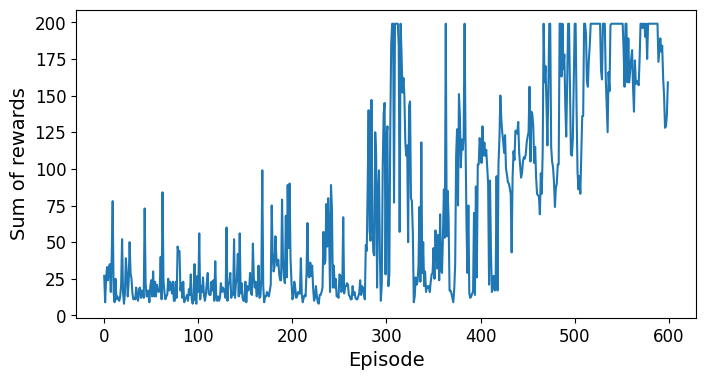

In [ ]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt

from collections import deque
from tqdm import tqdm

import gym

env = gym.make("CartPole-v1", new_step_api=True)
input_shape = [4]     # env.observation_space.shape, the same as (4,)
n_outputs = 2         # env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

replay_memory = deque(maxlen=2000)   # double-ended queue

def epsilon_greedy_policy(state, epsilon=0):  # default greedy
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)
        return np.argmax(Q_values[0])

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

# def play_one_step(state, epsilon):
#    action = epsilon_greedy_policy(state, epsilon)
#    next_state, reward, done, info, _ = env.step(action)#
#    replay_memory.append((state, action, reward, next_state, done))
#    return next_state, reward, done, info


batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    next_Q_values = model.predict(next_states, verbose=0)

    # max_next_Q_values = np.max(next_Q_values, axis=1)  # DQN

    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask).sum(axis=1)
    ###

    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)

    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

# takes 36 min to train with 600 episodes in Colab
for episode in tqdm(range(600)):
    state = env.reset()   # obs is the state
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)    # go from 1 down to 0.01

        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, info, _ = env.step(action)
        replay_memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            break

    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown

    if episode > 50:
        training_step(batch_size)
        ###
        if episode % 20 == 0:     # 50
            target.set_weights(model.get_weights())
        ###

model.set_weights(best_weights)

plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

# Exercise

## Deque vs Rotating List

The `deque` class offers fast append, but fairly slow random access (for large replay memories):

In [ ]:
from collections import deque
np.random.seed(42)

mem = deque(maxlen=1000000)
for i in range(1000000):
    mem.append(i)
[mem[i] for i in np.random.randint(1000000, size=5)]

[121958, 671155, 131932, 365838, 259178]

In [ ]:
%timeit mem.append(1)

65.3 ns ± 1.74 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [ ]:
%timeit [mem[i] for i in np.random.randint(1000000, size=5)]

250 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Alternatively, you could use a rotating list like this `ReplayMemory` class. This would make random access faster for large replay memories:

In [ ]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=np.object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [ ]:
mem = ReplayMemory(max_size=1000000)
for i in range(1000000):
    mem.append(i)
mem.sample(5)

<ipython-input-5-120833403fb4>:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.buffer = np.empty(max_size, dtype=np.object)


array([757386, 904203, 190588, 595754, 865356], dtype=object)

In [ ]:
%timeit mem.append(1)

527 ns ± 5.12 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [ ]:
%timeit mem.sample(5)

12.6 µs ± 639 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Multi-output Regression
- tf.keras.losses.mean_squared_error
- tf.keras.losses.MeanSquaredError()

In [ ]:
# multi-output regression
y_true = [[0., 1.], [0., 1.]]
y_pred = [[1., 1.], [1., 0.3]]

mse = tf.keras.losses.MeanSquaredError()   # class version -> the averaged one
print(mse(y_true, y_pred), end='\n\n')

mse = tf.keras.losses.mean_squared_error   # function version -> per each output
print(mse(y_true, y_pred))
print(tf.reduce_mean(mse(y_true, y_pred)))

tf.Tensor(0.6225, shape=(), dtype=float32)

tf.Tensor([0.5   0.745], shape=(2,), dtype=float32)
tf.Tensor(0.6225, shape=(), dtype=float32)
